In [1]:
# import all packages
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
# set display options
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',200)
pd.set_option('display.width',200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
kwargs = dict(skipinitialspace=False,engine='c',encoding='ISO-8859-1')


import gc

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import confusion_matrix,classification_report

## Read in the main data file

In [2]:
%%time

df = pd.read_csv('../10262021_Update_Eng/yoy_hp_dem_util_cahps.csv')
print(df.shape)


(4995430, 190)
Wall time: 2min 39s


## Review Potential Target Columns

In [3]:
# 100104: Diabetes - EYE
# 100107: Diabetes - Kidney
# 101803: Controlling high blood pressure
# 201180: Diabetes Adherence
# 999998: Diabetes Blood Sugar Controlled
TARGET_COLS = ['100104','100107','101803','201180','999998']
df[TARGET_COLS].describe()

,100104,100107,101803,201180,999998
count,739880.000,733365.000,1128708.000,2183350.000,739880.000
mean,0.649,0.933,0.426,0.869,0.525
std,0.477,0.250,0.494,0.337,0.499
min,0.000,0.000,0.000,0.000,0.000
25%,0.000,1.000,0.000,1.000,0.000
50%,1.000,1.000,0.000,1.000,1.000
75%,1.000,1.000,1.000,1.000,1.000
max,1.000,1.000,1.000,1.000,1.000


In [4]:
# print(*list(df.columns),sep='\n')

In [5]:
cols = [
'MEDICARE_NUMBER',
# 'Member_ID',
# 'Eff_Date',
# 'Term_Date',
# 'Mbr_Mths',
# 'Contract_Number',
# 'PBP',
# 'Product',
# 'CMS_County',
# 'CMS_State',
# 'NEW_REGION',
# 'MA_Territory',
# 'DOB',
'Age',
'Gender',
# 'Zip',
# 'FIPS',
'Plan_Type',
# 'dual_Status',
# 'PCP_Name',
# 'PCP_Tax_ID',
# 'GroupName',
# 'GroupNumber',
# 'GroupSegment',
# 'GroupSegmentName',
# 'TRR_Parent_Name',
# 'TOH_Name',
# 'Recruiter_Name',
# 'Writing_Agent_Name',
# 'Sales_Channel',
# 'New_Market',
'SNP',
'LIS_Flag',
# 'Enroll_Status',
# 'Issued_Status',
# 'Group_Status',
# 'AEP2018_Denom',
# 'AEP2018_Lapse',
'YEAR',
# 'AEP2019_Denom',
# 'AEP2019_Lapse',
# 'AEP2020_Denom',
# 'AEP2020_Lapse',
# 'AEP2021_Denom',
# 'AEP2021_Lapse',
'yoys',
# 'has_dem',
# 'SRC_MEMBER_ID_x',
# 'RUNYEAR',
# 'ITERATION',
# 'GNC_Den_Final',
# 'GACQ_Den_Final',
# 'HPCS_Den_Final',
# 'GNP_Den_Final',
# 'CC_Den_Final',
# 'Plan_R_Den_Final',
# 'Care_R_Den_Final',
# 'RX_R_Den_Final',
# 'GNC',
# 'GACQ',
# 'HPCS',
# 'GNP',
# 'CC',
# 'Plan_R',
# 'Care_R',
# 'RX_R',
# 'RX_Rating_Class',
# 'CARE_Rating_Class',
# 'PLAN_Rating_Class',
# 'GNC_Class',
# 'GCQ_Class',
# 'CS_Class',
# 'CC_Class',
# 'GNP_Class',
# 'PERIOD_STUDIED',
# 'dem_year',
# 'has_cahps',
# 'HICN_NBR',
'100104',
'100107',
# '101201',
# '101603',
# '102401',
# '104201',
# '107107',
# '107110',
# '107125',
# '107126',
# '107127',
'201180',
# '201181',
# '201182',
# '201183',
# '201184',
# '201507',
'999998',
# 'HP_YEAR',
'101803',
# '600070',
# 'has_hp',
# 'SRC_MEMBER_ID_y',
# 'EMERG_TRANSACTIONS',
# 'PCP_TRANSACTIONS',
# 'SPCLST_TRANSACTIONS',
# 'IP_TRANSACTIONS',
# 'EMERG_VISITS',
'PRIMARY_CARE_VISITS',
# 'SPCLST_VISITS',
# 'IP_VISITS',
# 'PREVENTIVE_CARE_VISITS',
# 'EMERG_BENEFIT_PAID_AMT',
# 'PCP_BENEFIT_PAID_AMT',
# 'SPCLST_BENEFIT_PAID_AMT',
# 'IP_BENEFIT_PAID_AMT',
# 'EMERG_MBR_PAID_AMT',
# 'PCP_MBR_PAID_AMT',
# 'SPCLST_MBR_PAID_AMT',
# 'IP_MBR_PAID_AMT',
# 'PAR_MED_CLAIM_COUNT',
# 'NONPAR_MED_CLAIM_COUNT',
# 'PAR_MED_VISITS',
# 'NONPAR_MED_VISITS',
# 'PAR_MED_BENEFIT_PAID_AMT',
# 'NONPAR_MED_BENEFIT_PAID_AMT',
# 'PAR_MED_MBR_PAID_AMT',
# 'NONPAR_MED_MBR_PAID_AMT',
'AETNA_MED_PAID_AMT',
'MBR_MED_PAID_AMT',
# 'TOTAL_MED_COST',
# 'MBR_MED_DEDUCTIBLE_PAID_AMT',
# 'PAR_MED_MBR_DEDUCTIBLE_PAID_AMT',
# 'NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT',
# 'AMBULANCE_CLAIM_COUNT',
# 'AMBULANCE_EVENT_COUNT',
# 'BEHAVIORAL_HEALTH_CLAIM_COUNT',
# 'BEHAVIORAL_HEALTH_VISITS',
# 'OP_TRANSACTIONS',
# 'OP_VISITS',
# 'OP_BENEFIT_PAID_AMT',
# 'OP_MBR_PAID_AMT',
'DR_TRANSACTIONS',
'DR_VISITS',
# 'DR_BENEFIT_PAID_AMT',
'DR_MBR_PAID_AMT',
'VISION_TRANSACTIONS',
# 'VISION_VISITS',
# 'TOTAL_ALLOWED_VISION',
# 'BENEFIT_PAID_VISION',
'MEM_PAID_VISION',
# 'PAR_AMT_VISION',
# 'NONPAR_AMT_VISION',
# 'PREV_TRANSACTIONS_DENTAL',
# 'COMP_TRANSACTIONS_DENTAL',
# 'PREV_ALLOWED_DENTAL',
# 'COMP_ALLOWED_DENTAL',
# 'TOTAL_ALLOWED_DENTAL',
# 'PREV_BENEFIT_PAID_DENTAL',
# 'COMP_BENEFIT_PAID_DENTAL',
# 'BENEFIT_PAID_DENTAL',
# 'PREV_MEM_PAID_DENTAL',
# 'COMP_MEM_PAID_DENTAL',
# 'MEM_PAID_DENTAL',
# 'PAR_AMT_DENTAL',
# 'NONPAR_AMT_DENTAL',
# 'PAR_VISITS_DENTAL',
# 'NONPAR_VISITS_DENTAL',
# 'TOTAL_ENCOUNTER_ALLOWED_HEARING',
# 'BENEFIT_ENCOUNTER_PAID_HEARING',
# 'MEM_ENCOUNTER_PAID_HEARING',
# 'TOTAL_ALLOWED_HEARING',
# 'BENEFIT_PAID_HEARING',
# 'MEM_PAID_HEARING',
# 'PAR_AMT_HEARING',
# 'NONPAR_AMT_HEARING',
# 'Order_Count_OTC',
# 'Call_or_Claim_Orders_OTC',
# 'Online_Orders_OTC',
# 'Store_Orders_OTC',
# 'Total_AMT_OTC',
# 'Call_or_Claim_AMT_OTC',
# 'Online_AMT_OTC',
# 'Store_AMT_OTC',
# 'Benefit_Paid_Amt_OTC',
# 'Mbr_Paid_Amt_OTC',
# 'has_util',
'PLAN',
# 'PLAN_YOY',
# 'yoy_Full_eligible',
# 'yoy_Part_C_eligible',
# 'yoy_Part_D_eligible'
]
yoy_cols = [
"PLAN","yoys",
# "CONTRACT",
# "PBP",
# "CY_PBPNAME",
# "CY_PRODUCT",
# "PLANTYPE",
# "CY_RENEWALTYPE",
# "CY_OPENACCESS",
# "REGION",
# "MARKET",
# "PLANGEONAME",
# "STATE",
# "CY_PRIMEPLAN",
# "CY_DEDUCTIBLEHMOINN",
# "CY_DEDUCTIBLEPPOANNUAL",
# "CY_DEDUCTIBLEPOSOON",
# "CY_HIGHDEDUCTIBLE",
# "CY_MOOPINN",
# "CY_MOOPCOMBINED",
# "CY_MOOPOON",
# "CY_PREMIUM",
# "CY_PARTBGIVE",
# "CY_INPATIENTSTAYMC",
# "CY_SNF",
# "CY_EMERGENCY",
# "CY_URGENTLYNEEDEDCARE",
# "CY_PCP_MIN",
# "CY_PCP",
# "CY_PCPREASONCD",
# "CY_CHIROPRACTICROUTINE",
# "CY_OCCUPATIONALTHERAPY",
# "CY_PHYSICIANSPECIALIST",
# "CY_DIAGNOSTICPROC",
# "CY_LAB_MIN",
# "CY_LAB",
# "CY_LABREASONCD",
# "CY_DIAGNOSTICRADIOLOGYCT",
# "CY_OUTPATIENTHOSP_MIN",
# "CY_OUTPATIENTHOSP",
# "CY_OUTPATIENTHOSPREASONCD",
# "CY_OUTPATIENTHOSPOBSERVATION_MIN",
# "CY_OUTPATIENTHOSPOBSERVATION",
# "CY_OUTPATIENTHOSPOBSERVATIONREASONCD",
# "CY_ASC",
# "CY_DIALYSIS",
# "CY_ACUPUNCTURE",
# "CY_OTCALLOWANCE",
# "CY_OTCPERIODICITYNMC",
# "CY_FITNESSVENDOR",
# "CY_TELEMONITORING",
# "CY_NURSINGHOTLINE",
# "CY_DENTALBENEFITADMINTYPE",
# "CY_PREVENTIVEDENTALBENTYPE",
# "CY_ORALFREQ",
# "CY_DENTALXRAYSFREQ",
# "CY_PREVDENTALALLOWANCE",
# "CY_PREVDENTALALLOWANCEFREQ",
# "CY_COMPREHENSIVEDENTALNMCBENTYPE",
# "CY_COMPDENTALALLOWANCE",
# "CY_EYEEXAMSMC",
# "CY_EYEEXAMSROUTINE",
# "CY_EYEWEARBENEFITADMINTYPE",
# "CY_EYEWEARNMCBENTYPE",
# "CY_EYEGLASSESFREQ",
# "CY_EYEWEARALLOWANCE",
# "CY_EYEWEARALLOWANCEFREQ",
# "CY_HEARINGEXAMROUTINEFREQ",
# "CY_HEARINGEXAMMC",
# "CY_HEARINGEXAMROUTINE",
# "CY_HEARINGAIDFITTING",
# "CY_HEARINGAIDBENEFITADMINTYPE",
# "CY_HEARINGAIDBENTYPE",
# "CY_HEARINGAIDALLFREQ",
# "CY_HEARINGAIDALLOWANCE",
# "CY_HEARINGAIDALLOWANCETYPE",
# "CY_HEARINGAIDALLOWANCEFREQ",
# "CY_FORMULARYNAME",
# "CY_RXDEDUCTIBLE",
# "CY_TIER0DEDUCTIBLEDOESNOTAPPLY",
# "CY_TIER1DEDUCTIBLEDOESNOTAPPLY",
# "CY_TIER2DEDUCTIBLEDOESNOTAPPLY",
# "CY_TIER3DEDUCTIBLEDOESNOTAPPLY",
# "CY_TIER4DEDUCTIBLEDOESNOTAPPLY",
# "CY_TIER5DEDUCTIBLEDOESNOTAPPLY",
# "CY_NETWORK",
# "CY_GAPCOVERAGE",
# "CY_TIER1PREFRETAIL1MO",
# "CY_TIER2PREFRETAIL1MO",
# "CY_TIER3PREFRETAIL1MO",
# "CY_TIER4PREFRETAIL1MO",
# "CY_TIER5PREFRETAIL1MO",
# "CY_TIER1PREFRETAIL3MO",
# "CY_TIER2PREFRETAIL3MO",
# "CY_URGENTLYNEEDEDCARE_COSTSHARETYPE",
# "CY_PCP_COSTSHARETYPE",
# "CY_LAB_COSTSHARETYPE",
# "CY_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE",
# "CY_OUTPATIENTHOSP_COSTSHARETYPE",
# "CY_ASC_COSTSHARETYPE",
# "CY_TRANSPORT_BENEFIT",
# "CY_MEAL_BENEFIT",
# "CY_DENTAL_COMBINED",
# "CY_HEARING_COMBINED",
# "CY_EYEWEAR_COMBINED",
# "CY_DENTALBENEFITADMINTYPE_GENERALIZED",
# "CY_EYEWEARBENEFITADMINTYPE_GENERALIZED",
# "CY_HEARINGAIDBENEFITADMINTYPE_GENERALIZED",
# "CY_DENTAL_COMBINED_GENERALIZED",
# "CY_HEARING_COMBINED_GENERALIZED",
# "CY_EYEWEAR_COMBINED_GENERALIZED",
# "CY_MEDICALDEDUCTIBLE",
# "NY_PBPNAME",
# "NY_PRODUCT",
# "NY_PLANTYPE",
# "NY_RENEWALTYPE",
# "NY_OPENACCESS",
# "NY_MARKET",
# "NY_PLANGEONAME",
# "NY_STATE",
# "NY_PRIMEPLAN",
# "NY_DEDUCTIBLEHMOINN",
# "NY_DEDUCTIBLEPPOANNUAL",
# "NY_DEDUCTIBLEPOSOON",
"NY_HIGHDEDUCTIBLE",
"NY_MOOPINN",
# "NY_MOOPCOMBINED",
# "NY_MOOPOON",
"NY_PREMIUM",
# "NY_PARTBGIVE",
# "NY_INPATIENTSTAYMC",
# "NY_SNF",
# "NY_EMERGENCY",
# "NY_URGENTLYNEEDEDCARE",
# "NY_PCP_MIN",
"NY_PCP",
# "NY_PCPREASONCD",
# "NY_CHIROPRACTICROUTINE",
# "NY_OCCUPATIONALTHERAPY",
# "NY_PHYSICIANSPECIALIST",
# "NY_DIAGNOSTICPROC",
# "NY_LAB_MIN",
"NY_LAB",
# "NY_LABREASONCD",
# "NY_DIAGNOSTICRADIOLOGYCT",
# "NY_OUTPATIENTHOSP_MIN",
# "NY_OUTPATIENTHOSP",
# "NY_OUTPATIENTHOSPREASONCD",
# "NY_OUTPATIENTHOSPOBSERVATION_MIN",
# "NY_OUTPATIENTHOSPOBSERVATION",
# "NY_OUTPATIENTHOSPOBSERVATIONREASONCD",
# "NY_ASC",
"NY_DIALYSIS",
# "NY_ACUPUNCTURE",
# "NY_OTCALLOWANCE",
# "NY_OTCPERIODICITYNMC",
# "NY_FITNESSVENDOR",
# "NY_TELEMONITORING",
# "NY_NURSINGHOTLINE",
# "NY_DENTALBENEFITADMINTYPE",
# "NY_PREVENTIVEDENTALBENTYPE",
# "NY_ORALFREQ",
# "NY_DENTALXRAYSFREQ",
# "NY_PREVDENTALALLOWANCE",
# "NY_PREVDENTALALLOWANCEFREQ",
# "NY_COMPREHENSIVEDENTALNMCBENTYPE",
# "NY_COMPDENTALALLOWANCE",
"NY_EYEEXAMSMC",
"NY_EYEEXAMSROUTINE",
# "NY_EYEWEARBENEFITADMINTYPE",
# "NY_EYEWEARNMCBENTYPE",
# "NY_EYEGLASSESFREQ",
# "NY_EYEWEARALLOWANCE",
# "NY_EYEWEARALLOWANCEFREQ",
# "NY_HEARINGEXAMROUTINEFREQ",
# "NY_HEARINGEXAMMC",
# "NY_HEARINGEXAMROUTINE",
# "NY_HEARINGAIDFITTING",
# "NY_HEARINGAIDBENEFITADMINTYPE",
# "NY_HEARINGAIDBENTYPE",
# "NY_HEARINGAIDALLFREQ",
# "NY_HEARINGAIDALLOWANCE",
# "NY_HEARINGAIDALLOWANCETYPE",
# "NY_HEARINGAIDALLOWANCEFREQ",
# "NY_FORMULARYNAME",
"NY_RXDEDUCTIBLE",
# "NY_TIER0DEDUCTIBLEDOESNOTAPPLY",
# "NY_TIER1DEDUCTIBLEDOESNOTAPPLY",
# "NY_TIER2DEDUCTIBLEDOESNOTAPPLY",
# "NY_TIER3DEDUCTIBLEDOESNOTAPPLY",
# "NY_TIER4DEDUCTIBLEDOESNOTAPPLY",
# "NY_TIER5DEDUCTIBLEDOESNOTAPPLY",
# "NY_NETWORK",
# "NY_GAPCOVERAGE",
"NY_TIER1PREFRETAIL1MO",
"NY_TIER2PREFRETAIL1MO",
# "NY_TIER3PREFRETAIL1MO",
# "NY_TIER4PREFRETAIL1MO",
# "NY_TIER5PREFRETAIL1MO",
"NY_TIER1PREFRETAIL3MO",
"NY_TIER2PREFRETAIL3MO",
# "NY_URGENTLYNEEDEDCARE_COSTSHARETYPE",
# "NY_PCP_COSTSHARETYPE",
# "NY_LAB_COSTSHARETYPE",
# "NY_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE",
# "NY_OUTPATIENTHOSP_COSTSHARETYPE",
# "NY_ASC_COSTSHARETYPE",
# "NY_TRANSPORT_BENEFIT",
# "NY_MEAL_BENEFIT",
# "NY_DENTAL_COMBINED",
# "NY_HEARING_COMBINED",
# "NY_EYEWEAR_COMBINED",
# "NY_DENTALBENEFITADMINTYPE_GENERALIZED",
# "NY_EYEWEARBENEFITADMINTYPE_GENERALIZED",
# "NY_HEARINGAIDBENEFITADMINTYPE_GENERALIZED",
# "NY_DENTAL_COMBINED_GENERALIZED",
# "NY_HEARING_COMBINED_GENERALIZED",
# "NY_EYEWEAR_COMBINED_GENERALIZED",
# "NY_MEDICALDEDUCTIBLE",
# "NY_PLAN",
# "YOY_DIFF_PBPNAME",
# "YOY_DIFF_PRODUCT",
# "YOY_DIFF_RENEWALTYPE",
# "YOY_DIFF_OPENACCESS",
# "YOY_DIFF_PRIMEPLAN",
# "YOY_DIFF_DEDUCTIBLEHMOINN",
# "YOY_DIFF_DEDUCTIBLEPPOANNUAL",
# "YOY_DIFF_DEDUCTIBLEPOSOON",
# "YOY_DIFF_HIGHDEDUCTIBLE",
"YOY_DIFF_MOOPINN",
# "YOY_DIFF_MOOPCOMBINED",
# "YOY_DIFF_MOOPOON",
"YOY_DIFF_PREMIUM",
# "YOY_DIFF_PARTBGIVE",
# "YOY_DIFF_INPATIENTSTAYMC",
# "YOY_DIFF_SNF",
# "YOY_DIFF_EMERGENCY",
# "YOY_DIFF_URGENTLYNEEDEDCARE",
# "YOY_DIFF_PCP_MIN",
"YOY_DIFF_PCP",
# "YOY_DIFF_PCPREASONCD",
# "YOY_DIFF_CHIROPRACTICROUTINE",
# "YOY_DIFF_OCCUPATIONALTHERAPY",
# "YOY_DIFF_PHYSICIANSPECIALIST",
# "YOY_DIFF_DIAGNOSTICPROC",
# "YOY_DIFF_LAB_MIN",
"YOY_DIFF_LAB",
# "YOY_DIFF_LABREASONCD",
# "YOY_DIFF_DIAGNOSTICRADIOLOGYCT",
# "YOY_DIFF_OUTPATIENTHOSP_MIN",
# "YOY_DIFF_OUTPATIENTHOSP",
# "YOY_DIFF_OUTPATIENTHOSPREASONCD",
# "YOY_DIFF_OUTPATIENTHOSPOBSERVATION_MIN",
# "YOY_DIFF_OUTPATIENTHOSPOBSERVATION",
# "YOY_DIFF_OUTPATIENTHOSPOBSERVATIONREASONCD",
# "YOY_DIFF_ASC",
"YOY_DIFF_DIALYSIS",
# "YOY_DIFF_ACUPUNCTURE",
# "YOY_DIFF_OTCALLOWANCE",
# "YOY_DIFF_OTCPERIODICITYNMC",
# "YOY_DIFF_FITNESSVENDOR",
# "YOY_DIFF_TELEMONITORING",
# "YOY_DIFF_NURSINGHOTLINE",
# "YOY_DIFF_DENTALBENEFITADMINTYPE",
# "YOY_DIFF_PREVENTIVEDENTALBENTYPE",
# "YOY_DIFF_ORALFREQ",
# "YOY_DIFF_DENTALXRAYSFREQ",
# "YOY_DIFF_PREVDENTALALLOWANCE",
# "YOY_DIFF_PREVDENTALALLOWANCEFREQ",
# "YOY_DIFF_COMPREHENSIVEDENTALNMCBENTYPE",
# "YOY_DIFF_COMPDENTALALLOWANCE",
"YOY_DIFF_EYEEXAMSMC",
"YOY_DIFF_EYEEXAMSROUTINE",
# "YOY_DIFF_EYEWEARBENEFITADMINTYPE",
# "YOY_DIFF_EYEWEARNMCBENTYPE",
# "YOY_DIFF_EYEGLASSESFREQ",
# "YOY_DIFF_EYEWEARALLOWANCE",
# "YOY_DIFF_EYEWEARALLOWANCEFREQ",
# "YOY_DIFF_HEARINGEXAMROUTINEFREQ",
# "YOY_DIFF_HEARINGEXAMMC",
# "YOY_DIFF_HEARINGEXAMROUTINE",
# "YOY_DIFF_HEARINGAIDFITTING",
# "YOY_DIFF_HEARINGAIDBENEFITADMINTYPE",
# "YOY_DIFF_HEARINGAIDBENTYPE",
# "YOY_DIFF_HEARINGAIDALLFREQ",
# "YOY_DIFF_HEARINGAIDALLOWANCE",
# "YOY_DIFF_HEARINGAIDALLOWANCETYPE",
# "YOY_DIFF_HEARINGAIDALLOWANCEFREQ",
# "YOY_DIFF_FORMULARYNAME",
"YOY_DIFF_RXDEDUCTIBLE",
# "YOY_DIFF_TIER0DEDUCTIBLEDOESNOTAPPLY",
# "YOY_DIFF_TIER1DEDUCTIBLEDOESNOTAPPLY",
# "YOY_DIFF_TIER2DEDUCTIBLEDOESNOTAPPLY",
# "YOY_DIFF_TIER3DEDUCTIBLEDOESNOTAPPLY",
# "YOY_DIFF_TIER4DEDUCTIBLEDOESNOTAPPLY",
# "YOY_DIFF_TIER5DEDUCTIBLEDOESNOTAPPLY",
# "YOY_DIFF_NETWORK",
# "YOY_DIFF_GAPCOVERAGE",
"YOY_DIFF_TIER1PREFRETAIL1MO",
"YOY_DIFF_TIER2PREFRETAIL1MO",
# "YOY_DIFF_TIER3PREFRETAIL1MO",
# "YOY_DIFF_TIER4PREFRETAIL1MO",
# "YOY_DIFF_TIER5PREFRETAIL1MO",
"YOY_DIFF_TIER1PREFRETAIL3MO",
"YOY_DIFF_TIER2PREFRETAIL3MO",
# "YOY_DIFF_URGENTLYNEEDEDCARE_COSTSHARETYPE",
# "YOY_DIFF_PCP_COSTSHARETYPE",
# "YOY_DIFF_LAB_COSTSHARETYPE",
# "YOY_DIFF_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE",
# "YOY_DIFF_OUTPATIENTHOSP_COSTSHARETYPE",
# "YOY_DIFF_ASC_COSTSHARETYPE",
# "YOY_DIFF_TRANSPORT_BENEFIT",
# "YOY_DIFF_MEAL_BENEFIT",
# "YOY_DIFF_DENTAL_AdminType_Preventive_Comprehensive_BenefitType",
# "YOY_DIFF_HEARING_COMBINED",
# "YOY_DIFF_EYEWEAR_COMBINED",
# "YOY_DIFF_DENTALBENEFITADMINTYPE_GENERALIZED",
# "YOY_DIFF_EYEWEARBENEFITADMINTYPE_GENERALIZED",
# "YOY_DIFF_HEARINGAIDBENEFITADMINTYPE_GENERALIZED",
# "YOY_DIFF_DENTAL_COMBINED_GENERALIZED",
# "YOY_DIFF_HEARING_COMBINED_GENERALIZED",
# "YOY_DIFF_EYEWEAR_COMBINED_GENERALIZED",
# "YOY_DIFF_MEDICALDEDUCTIBLE",
# "Consolidated PLAN Ind",
# "Change_PBPNAME",
# "Change_PRODUCT",
# "Change_RENEWALTYPE",
# "Open Access Ind",
# "Prime Plan Ind",
# "Change_DEDUCTIBLEHMOINN",
# "Change_DEDUCTIBLEPPOANNUAL",
# "Change_DEDUCTIBLEPOSOON",
# "HIGHDEDUCTIBLE Ind",
# "Max Out Of Pocket Ind",
# "MOOPCOMBINED Ind",
# "Change_MOOPOON",
# "Premium Ind",
# "Part B Give Ind",
# "Inpatient Copay Ind",
# "Change_SNF",
# "Change_EMERGENCY",
# "Urgently Needed Care Ind",
# "Change_PCP_MIN",
# "PCP Ind",
# "Change_PCPREASONCD",
# "Change_CHIROPRACTICROUTINE",
# "Change_OCCUPATIONALTHERAPY",
# "Physician Specialist Ind",
# "Change_DIAGNOSTICPROC",
# "Change_LAB_MIN",
# "LAB Ind",
# "Change_LABREASONCD",
# "Change_DIAGNOSTICRADIOLOGYCT",
# "Change_OUTPATIENTHOSP_MIN",
# "Outpatient Hosp Ind",
# "Change_OUTPATIENTHOSPREASONCD",
# "Change_OUTPATIENTHOSPOBSERVATION_MIN",
# "Change_OUTPATIENTHOSPOBSERVATION",
# "Change_OUTPATIENTHOSPOBSERVATIONREASONCD",
# "ASC Copay Ind",
# "Change_DIALYSIS",
# "Change_ACUPUNCTURE",
# "OTC Allowance Ind",
# "OTC period Ind",
# "Change_FITNESSVENDOR",
# "Change_TELEMONITORING",
# "Change_NURSINGHOTLINE",
# "Change_DENTALBENEFITADMINTYPE",
# "Change_PREVENTIVEDENTALBENTYPE",
# "Change_ORALFREQ",
# "Change_DENTALXRAYSFREQ",
# "PrevDental Allowance Ind",
# "Change_PREVDENTALALLOWANCEFREQ",
# "Change_COMPREHENSIVEDENTALNMCBENTYPE",
# "Change_COMPDENTALALLOWANCE",
# "Change_EYEEXAMSMC",
# "Change_EYEEXAMSROUTINE",
# "Change_EYEWEARBENEFITADMINTYPE",
# "Change_EYEWEARNMCBENTYPE",
# "Change_EYEGLASSESFREQ",
# "Eyewear Allowance Ind",
# "Change_EYEWEARALLOWANCEFREQ",
# "Change_HEARINGEXAMROUTINEFREQ",
# "Change_HEARINGEXAMMC",
# "Change_HEARINGEXAMROUTINE",
# "Change_HEARINGAIDFITTING",
# "Change_HEARINGAIDBENEFITADMINTYPE",
# "Change_HEARINGAIDBENTYPE",
# "Change_HEARINGAIDALLFREQ",
# "Hearing AID Allowance Ind",
# "Change_HEARINGAIDALLOWANCETYPE",
# "Change_HEARINGAIDALLOWANCEFREQ",
# "FORMULARYNAME Ind",
# "RX Deductible Change Ind",
# "Change_TIER0DEDUCTIBLEDOESNOTAPPLY",
# "Change_TIER1DEDUCTIBLEDOESNOTAPPLY",
# "Change_TIER2DEDUCTIBLEDOESNOTAPPLY",
# "TIER3DEDUCTIBLEDOESNOTAPPLY Ind",
# "Change_TIER4DEDUCTIBLEDOESNOTAPPLY",
# "Change_TIER5DEDUCTIBLEDOESNOTAPPLY",
# "Pharmacy Network Ind",
# "Change_GAPCOVERAGE",
# "Tier1 Pref Copay Ind",
# "Tier2 Pref Copay Ind",
# "Change_TIER3PREFRETAIL1MO",
# "Change_TIER4PREFRETAIL1MO",
# "Change_TIER5PREFRETAIL1MO",
# "Change_TIER1PREFRETAIL3MO",
# "Change_TIER2PREFRETAIL3MO",
# "Change_URGENTLYNEEDEDCARE_COSTSHARETYPE",
# "Change_PCP_COSTSHARETYPE",
# "Change_LAB_COSTSHARETYPE",
# "Change_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE",
# "Change_OUTPATIENTHOSP_COSTSHARETYPE",
# "Change_ASC_COSTSHARETYPE",
# "Transport Ind",
# "Meal Ind",
# "Dental Ind",
# "Hearing Ind",
# "Eyewear Ind",
# "Change_DENTALBENEFITADMINTYPE_GENERALIZED",
# "Change_EYEWEARBENEFITADMINTYPE_GENERALIZED",
# "Change_HEARINGAIDBENEFITADMINTYPE_GENERALIZED",
# "Change_DENTAL_COMBINED_GENERALIZED",
# "Change_HEARING_COMBINED_GENERALIZED",
# "Change_EYEWEAR_COMBINED_GENERALIZED",
# "Medical Deductible Ind",
# "YEAR",
# "total_disruption",
# "total_supplementary benefit_disruptions",
# "Total_supplementary_#of_Benefits",
# "total_part_c benefit_disruptions",
# "Total_PartC_#of_Benefits",
# "total_part_d benefit_disruptions",
# "Total_PartD_#of_Benefits",
"yoy_Part_D_eligible",
"yoy_Part_C_eligible",
"yoy_Full_eligible"
]

In [6]:
test = df[cols]

In [7]:
"""cols = [
    # Identify demographic columns
#     'Contract_Number',
#     'PBP',
    'MEDICARE_NUMBER',
    'PLAN',
    'Age',
    'Gender',
    'Plan_Type',
    'SNP',
    'LIS_Flag',
    'YEAR',
    'yoys',
    
    # Identify the filter columns
    
#     'Full_yoy_eligible',
#     'Part_C_yoy_eligible',
#     'Part_D_yoy_eligible',
    
    # Identify potential target columns
    '100104',
    '100107',
    '101803',
    '201180',
    '999998',
    
    # Identify relevant utilization columns
    'PRIMARY_CARE_VISITS',
    'PCP_TRANSACTIONS',
    'TOTAL_MED_COST',
    'AETNA_MED_PAID_AMT',
    'DR_VISITS',
    'DR_TRANSACTIONS',
    'VISION_TRANSACTIONS'
]

test = df[cols]"""

"cols = [\n    # Identify demographic columns\n#     'Contract_Number',\n#     'PBP',\n    'MEDICARE_NUMBER',\n    'PLAN',\n    'Age',\n    'Gender',\n    'Plan_Type',\n    'SNP',\n    'LIS_Flag',\n    'YEAR',\n    'yoys',\n    \n    # Identify the filter columns\n    \n#     'Full_yoy_eligible',\n#     'Part_C_yoy_eligible',\n#     'Part_D_yoy_eligible',\n    \n    # Identify potential target columns\n    '100104',\n    '100107',\n    '101803',\n    '201180',\n    '999998',\n    \n    # Identify relevant utilization columns\n    'PRIMARY_CARE_VISITS',\n    'PCP_TRANSACTIONS',\n    'TOTAL_MED_COST',\n    'AETNA_MED_PAID_AMT',\n    'DR_VISITS',\n    'DR_TRANSACTIONS',\n    'VISION_TRANSACTIONS'\n]\n\ntest = df[cols]"

## Begin Filtering Dataset to Desired Demographic

In [8]:
test['LIS_Flag'].value_counts(dropna=False)

nan      4158592
1.000     475145
2.000     197159
3.000     104457
4.000      60077
Name: LIS_Flag, dtype: int64

In [9]:
test = test[test['LIS_Flag'].isnull()]

In [10]:
test['SNP'].value_counts(dropna=False)

N      3050458
NaN    1107640
Y          494
Name: SNP, dtype: int64

In [11]:
test = test[(test['SNP'].isnull()) | (test['SNP'] == 'N')]

In [12]:
test['yoys'].value_counts()

2020-2021    1234536
2019-2020    1138061
2018-2019    1002898
2017-2018     782603
Name: yoys, dtype: int64

In [13]:
# Dropping 2020-2021 because we don't have completed Hedis PS measures
test = test[test['yoys'].isin(['2018-2019','2019-2020'])]

In [14]:
test.drop(['SNP','LIS_Flag'],axis=1,inplace=True)

## Read in Benefit Values

In [15]:
yoy1819 = pd.read_excel('../10262021_Update_Eng/YOY_2018-2019_data_for_Bid_Model_20Oct2021.xlsx')
yoy1920 = pd.read_excel('../10262021_Update_Eng/YOY_2019-2020_data_for_Bid_Model_20Oct2021.xlsx')
yoy2021 = pd.read_excel('../10262021_Update_Eng/YOY_2020-2021_data_for_Bid_Model_20Oct2021.xlsx')

cols1819 = list(yoy1819.columns)
cols1920 = list(yoy1920.columns)
cols2021 = list(yoy2021.columns)

cols_to_keep = [value for value in cols1819 if value in cols1920]
cols_to_keep = [value for value in cols_to_keep if value in cols2021]

yoy1819 = yoy1819[cols_to_keep]
yoy1920 = yoy1920[cols_to_keep]
yoy2021 = yoy2021[cols_to_keep] 

display(yoy1819.sample(2))
display(yoy1920.sample(2))
display(yoy2021.sample(2))

yoy1819['yoys'] = '2018-2019'
yoy1920['yoys'] = '2019-2020'
yoy2021['yoys'] = '2020-2021'

yoy = pd.concat([yoy1819,yoy1920,yoy2021]).reset_index(drop=True)

yoy['yoy_Part_D_eligible'] = yoy['total_part_d benefit_disruptions'].apply(lambda x: 1 if x >= 1 else np.nan)
yoy['yoy_Part_C_eligible'] = yoy['total_part_c benefit_disruptions'].apply(lambda x: 1 if x >= 1 else np.nan)
yoy['yoy_Full_eligible']   = (yoy['yoy_Part_C_eligible']>= 1) | (yoy['yoy_Part_D_eligible']>= 1)
yoy['yoy_Full_eligible'] = yoy['yoy_Full_eligible'].apply(lambda x: 1 if x else np.nan)
print(yoy.shape)
print(*list(yoy.columns),sep='\n')

,CONTRACT,PBP,CY_PBPNAME,CY_PRODUCT,PLANTYPE,CY_RENEWALTYPE,CY_OPENACCESS,REGION,MARKET,PLANGEONAME,STATE,CY_PRIMEPLAN,CY_DEDUCTIBLEHMOINN,CY_DEDUCTIBLEPPOANNUAL,CY_DEDUCTIBLEPOSOON,CY_HIGHDEDUCTIBLE,CY_MOOPINN,CY_MOOPCOMBINED,CY_MOOPOON,CY_PREMIUM,CY_PARTBGIVE,CY_INPATIENTSTAYMC,CY_SNF,CY_EMERGENCY,CY_URGENTLYNEEDEDCARE,CY_PCP_MIN,CY_PCP,CY_PCPREASONCD,CY_CHIROPRACTICROUTINE,CY_OCCUPATIONALTHERAPY,CY_PHYSICIANSPECIALIST,CY_DIAGNOSTICPROC,CY_LAB_MIN,CY_LAB,CY_LABREASONCD,CY_DIAGNOSTICRADIOLOGYCT,CY_OUTPATIENTHOSP_MIN,CY_OUTPATIENTHOSP,CY_OUTPATIENTHOSPREASONCD,CY_OUTPATIENTHOSPOBSERVATION_MIN,CY_OUTPATIENTHOSPOBSERVATION,CY_OUTPATIENTHOSPOBSERVATIONREASONCD,CY_ASC,CY_DIALYSIS,CY_ACUPUNCTURE,CY_OTCALLOWANCE,CY_OTCPERIODICITYNMC,CY_FITNESSVENDOR,CY_TELEMONITORING,CY_NURSINGHOTLINE,CY_DENTALBENEFITADMINTYPE,CY_PREVENTIVEDENTALBENTYPE,CY_ORALFREQ,CY_DENTALXRAYSFREQ,CY_PREVDENTALALLOWANCE,CY_PREVDENTALALLOWANCEFREQ,CY_COMPREHENSIVEDENTALNMCBENTYPE,CY_COMPDENTALALLOWANCE,CY_EYEEXAMSMC,CY_EYEEXAMSROUTINE,CY_EYEWEARBENEFITADMINTYPE,CY_EYEWEARNMCBENTYPE,CY_EYEGLASSESFREQ,CY_EYEWEARALLOWANCE,CY_EYEWEARALLOWANCEFREQ,CY_HEARINGEXAMROUTINEFREQ,CY_HEARINGEXAMMC,CY_HEARINGEXAMROUTINE,CY_HEARINGAIDFITTING,CY_HEARINGAIDBENEFITADMINTYPE,CY_HEARINGAIDBENTYPE,CY_HEARINGAIDALLFREQ,CY_HEARINGAIDALLOWANCE,CY_HEARINGAIDALLOWANCETYPE,CY_HEARINGAIDALLOWANCEFREQ,CY_FORMULARYNAME,CY_RXDEDUCTIBLE,CY_TIER0DEDUCTIBLEDOESNOTAPPLY,CY_TIER1DEDUCTIBLEDOESNOTAPPLY,CY_TIER2DEDUCTIBLEDOESNOTAPPLY,CY_TIER3DEDUCTIBLEDOESNOTAPPLY,CY_TIER4DEDUCTIBLEDOESNOTAPPLY,CY_TIER5DEDUCTIBLEDOESNOTAPPLY,CY_NETWORK,CY_GAPCOVERAGE,CY_TIER1PREFRETAIL1MO,CY_TIER2PREFRETAIL1MO,CY_TIER3PREFRETAIL1MO,CY_TIER4PREFRETAIL1MO,CY_TIER5PREFRETAIL1MO,CY_TIER1PREFRETAIL3MO,CY_TIER2PREFRETAIL3MO,CY_URGENTLYNEEDEDCARE_COSTSHARETYPE,CY_PCP_COSTSHARETYPE,CY_LAB_COSTSHARETYPE,CY_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE,CY_OUTPATIENTHOSP_COSTSHARETYPE,CY_ASC_COSTSHARETYPE,CY_TRANSPORT_BENEFIT,CY_MEAL_BENEFIT,...,Change_MOOPOON,Premium Ind,Part B Give Ind,Inpatient Copay Ind,Change_SNF,Change_EMERGENCY,Urgently Needed Care Ind,Change_PCP_MIN,PCP Ind,Change_PCPREASONCD,Change_CHIROPRACTICROUTINE,Change_OCCUPATIONALTHERAPY,Physician Specialist Ind,Change_DIAGNOSTICPROC,Change_LAB_MIN,LAB Ind,Change_LABREASONCD,Change_DIAGNOSTICRADIOLOGYCT,Change_OUTPATIENTHOSP_MIN,Outpatient Hosp Ind,Change_OUTPATIENTHOSPREASONCD,Change_OUTPATIENTHOSPOBSERVATION_MIN,Change_OUTPATIENTHOSPOBSERVATION,Change_OUTPATIENTHOSPOBSERVATIONREASONCD,ASC Copay Ind,Change_DIALYSIS,Change_ACUPUNCTURE,OTC Allowance Ind,OTC period Ind,Change_FITNESSVENDOR,Change_TELEMONITORING,Change_NURSINGHOTLINE,Change_DENTALBENEFITADMINTYPE,Change_PREVENTIVEDENTALBENTYPE,Change_ORALFREQ,Change_DENTALXRAYSFREQ,PrevDental Allowance Ind,Change_PREVDENTALALLOWANCEFREQ,Change_COMPREHENSIVEDENTALNMCBENTYPE,Change_COMPDENTALALLOWANCE,Change_EYEEXAMSMC,Change_EYEEXAMSROUTINE,Change_EYEWEARBENEFITADMINTYPE,Change_EYEWEARNMCBENTYPE,Change_EYEGLASSESFREQ,Eyewear Allowance Ind,Change_EYEWEARALLOWANCEFREQ,Change_HEARINGEXAMROUTINEFREQ,Change_HEARINGEXAMMC,Change_HEARINGEXAMROUTINE,Change_HEARINGAIDFITTING,Change_HEARINGAIDBENEFITADMINTYPE,Change_HEARINGAIDBENTYPE,Change_HEARINGAIDALLFREQ,Hearing AID Allowance Ind,Change_HEARINGAIDALLOWANCETYPE,Change_HEARINGAIDALLOWANCEFREQ,FORMULARYNAME Ind,RX Deductible Change Ind,Change_TIER0DEDUCTIBLEDOESNOTAPPLY,Change_TIER1DEDUCTIBLEDOESNOTAPPLY,Change_TIER2DEDUCTIBLEDOESNOTAPPLY,TIER3DEDUCTIBLEDOESNOTAPPLY Ind,Change_TIER4DEDUCTIBLEDOESNOTAPPLY,Change_TIER5DEDUCTIBLEDOESNOTAPPLY,Pharmacy Network Ind,Change_GAPCOVERAGE,Tier1 Pref Copay Ind,Tier2 Pref Copay Ind,Change_TIER3PREFRETAIL1MO,Change_TIER4PREFRETAIL1MO,Change_TIER5PREFRETAIL1MO,Change_TIER1PREFRETAIL3MO,Change_TIER2PREFRETAIL3MO,Change_URGENTLYNEEDEDCARE_COSTSHARETYPE,Change_PCP_COSTSHARETYPE,Change_LAB_COSTSHARETYPE,Change_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE,Change_OUTPATIENTHOSP_COSTSHARETYPE,Change_ASC_COSTSHARETYPE,Transport Ind,Meal Ind,Dental Ind,Hearing Ind,Eye

,CONTRACT,PBP,CY_PBPNAME,CY_PRODUCT,PLANTYPE,CY_RENEWALTYPE,CY_OPENACCESS,REGION,MARKET,PLANGEONAME,STATE,CY_PRIMEPLAN,CY_DEDUCTIBLEHMOINN,CY_DEDUCTIBLEPPOANNUAL,CY_DEDUCTIBLEPOSOON,CY_HIGHDEDUCTIBLE,CY_MOOPINN,CY_MOOPCOMBINED,CY_MOOPOON,CY_PREMIUM,CY_PARTBGIVE,CY_INPATIENTSTAYMC,CY_SNF,CY_EMERGENCY,CY_URGENTLYNEEDEDCARE,CY_PCP_MIN,CY_PCP,CY_PCPREASONCD,CY_CHIROPRACTICROUTINE,CY_OCCUPATIONALTHERAPY,CY_PHYSICIANSPECIALIST,CY_DIAGNOSTICPROC,CY_LAB_MIN,CY_LAB,CY_LABREASONCD,CY_DIAGNOSTICRADIOLOGYCT,CY_OUTPATIENTHOSP_MIN,CY_OUTPATIENTHOSP,CY_OUTPATIENTHOSPREASONCD,CY_OUTPATIENTHOSPOBSERVATION_MIN,CY_OUTPATIENTHOSPOBSERVATION,CY_OUTPATIENTHOSPOBSERVATIONREASONCD,CY_ASC,CY_DIALYSIS,CY_ACUPUNCTURE,CY_OTCALLOWANCE,CY_OTCPERIODICITYNMC,CY_FITNESSVENDOR,CY_TELEMONITORING,CY_NURSINGHOTLINE,CY_DENTALBENEFITADMINTYPE,CY_PREVENTIVEDENTALBENTYPE,CY_ORALFREQ,CY_DENTALXRAYSFREQ,CY_PREVDENTALALLOWANCE,CY_PREVDENTALALLOWANCEFREQ,CY_COMPREHENSIVEDENTALNMCBENTYPE,CY_COMPDENTALALLOWANCE,CY_EYEEXAMSMC,CY_EYEEXAMSROUTINE,CY_EYEWEARBENEFITADMINTYPE,CY_EYEWEARNMCBENTYPE,CY_EYEGLASSESFREQ,CY_EYEWEARALLOWANCE,CY_EYEWEARALLOWANCEFREQ,CY_HEARINGEXAMROUTINEFREQ,CY_HEARINGEXAMMC,CY_HEARINGEXAMROUTINE,CY_HEARINGAIDFITTING,CY_HEARINGAIDBENEFITADMINTYPE,CY_HEARINGAIDBENTYPE,CY_HEARINGAIDALLFREQ,CY_HEARINGAIDALLOWANCE,CY_HEARINGAIDALLOWANCETYPE,CY_HEARINGAIDALLOWANCEFREQ,CY_FORMULARYNAME,CY_RXDEDUCTIBLE,CY_TIER0DEDUCTIBLEDOESNOTAPPLY,CY_TIER1DEDUCTIBLEDOESNOTAPPLY,CY_TIER2DEDUCTIBLEDOESNOTAPPLY,CY_TIER3DEDUCTIBLEDOESNOTAPPLY,CY_TIER4DEDUCTIBLEDOESNOTAPPLY,CY_TIER5DEDUCTIBLEDOESNOTAPPLY,CY_NETWORK,CY_GAPCOVERAGE,CY_TIER1PREFRETAIL1MO,CY_TIER2PREFRETAIL1MO,CY_TIER3PREFRETAIL1MO,CY_TIER4PREFRETAIL1MO,CY_TIER5PREFRETAIL1MO,CY_TIER1PREFRETAIL3MO,CY_TIER2PREFRETAIL3MO,CY_URGENTLYNEEDEDCARE_COSTSHARETYPE,CY_PCP_COSTSHARETYPE,CY_LAB_COSTSHARETYPE,CY_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE,CY_OUTPATIENTHOSP_COSTSHARETYPE,CY_ASC_COSTSHARETYPE,CY_TRANSPORT_BENEFIT,CY_MEAL_BENEFIT,...,Change_MOOPOON,Premium Ind,Part B Give Ind,Inpatient Copay Ind,Change_SNF,Change_EMERGENCY,Urgently Needed Care Ind,Change_PCP_MIN,PCP Ind,Change_PCPREASONCD,Change_CHIROPRACTICROUTINE,Change_OCCUPATIONALTHERAPY,Physician Specialist Ind,Change_DIAGNOSTICPROC,Change_LAB_MIN,LAB Ind,Change_LABREASONCD,Change_DIAGNOSTICRADIOLOGYCT,Change_OUTPATIENTHOSP_MIN,Outpatient Hosp Ind,Change_OUTPATIENTHOSPREASONCD,Change_OUTPATIENTHOSPOBSERVATION_MIN,Change_OUTPATIENTHOSPOBSERVATION,Change_OUTPATIENTHOSPOBSERVATIONREASONCD,ASC Copay Ind,Change_DIALYSIS,Change_ACUPUNCTURE,OTC Allowance Ind,OTC period Ind,Change_FITNESSVENDOR,Change_TELEMONITORING,Change_NURSINGHOTLINE,Change_DENTALBENEFITADMINTYPE,Change_PREVENTIVEDENTALBENTYPE,Change_ORALFREQ,Change_DENTALXRAYSFREQ,PrevDental Allowance Ind,Change_PREVDENTALALLOWANCEFREQ,Change_COMPREHENSIVEDENTALNMCBENTYPE,Change_COMPDENTALALLOWANCE,Change_EYEEXAMSMC,Change_EYEEXAMSROUTINE,Change_EYEWEARBENEFITADMINTYPE,Change_EYEWEARNMCBENTYPE,Change_EYEGLASSESFREQ,Eyewear Allowance Ind,Change_EYEWEARALLOWANCEFREQ,Change_HEARINGEXAMROUTINEFREQ,Change_HEARINGEXAMMC,Change_HEARINGEXAMROUTINE,Change_HEARINGAIDFITTING,Change_HEARINGAIDBENEFITADMINTYPE,Change_HEARINGAIDBENTYPE,Change_HEARINGAIDALLFREQ,Hearing AID Allowance Ind,Change_HEARINGAIDALLOWANCETYPE,Change_HEARINGAIDALLOWANCEFREQ,FORMULARYNAME Ind,RX Deductible Change Ind,Change_TIER0DEDUCTIBLEDOESNOTAPPLY,Change_TIER1DEDUCTIBLEDOESNOTAPPLY,Change_TIER2DEDUCTIBLEDOESNOTAPPLY,TIER3DEDUCTIBLEDOESNOTAPPLY Ind,Change_TIER4DEDUCTIBLEDOESNOTAPPLY,Change_TIER5DEDUCTIBLEDOESNOTAPPLY,Pharmacy Network Ind,Change_GAPCOVERAGE,Tier1 Pref Copay Ind,Tier2 Pref Copay Ind,Change_TIER3PREFRETAIL1MO,Change_TIER4PREFRETAIL1MO,Change_TIER5PREFRETAIL1MO,Change_TIER1PREFRETAIL3MO,Change_TIER2PREFRETAIL3MO,Change_URGENTLYNEEDEDCARE_COSTSHARETYPE,Change_PCP_COSTSHARETYPE,Change_LAB_COSTSHARETYPE,Change_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE,Change_OUTPATIENTHOSP_COSTSHARETYPE,Change_ASC_COSTSHARETYPE,Transport Ind,Meal Ind,Dental Ind,Hearing Ind,Eye

,CONTRACT,PBP,CY_PBPNAME,CY_PRODUCT,PLANTYPE,CY_RENEWALTYPE,CY_OPENACCESS,REGION,MARKET,PLANGEONAME,STATE,CY_PRIMEPLAN,CY_DEDUCTIBLEHMOINN,CY_DEDUCTIBLEPPOANNUAL,CY_DEDUCTIBLEPOSOON,CY_HIGHDEDUCTIBLE,CY_MOOPINN,CY_MOOPCOMBINED,CY_MOOPOON,CY_PREMIUM,CY_PARTBGIVE,CY_INPATIENTSTAYMC,CY_SNF,CY_EMERGENCY,CY_URGENTLYNEEDEDCARE,CY_PCP_MIN,CY_PCP,CY_PCPREASONCD,CY_CHIROPRACTICROUTINE,CY_OCCUPATIONALTHERAPY,CY_PHYSICIANSPECIALIST,CY_DIAGNOSTICPROC,CY_LAB_MIN,CY_LAB,CY_LABREASONCD,CY_DIAGNOSTICRADIOLOGYCT,CY_OUTPATIENTHOSP_MIN,CY_OUTPATIENTHOSP,CY_OUTPATIENTHOSPREASONCD,CY_OUTPATIENTHOSPOBSERVATION_MIN,CY_OUTPATIENTHOSPOBSERVATION,CY_OUTPATIENTHOSPOBSERVATIONREASONCD,CY_ASC,CY_DIALYSIS,CY_ACUPUNCTURE,CY_OTCALLOWANCE,CY_OTCPERIODICITYNMC,CY_FITNESSVENDOR,CY_TELEMONITORING,CY_NURSINGHOTLINE,CY_DENTALBENEFITADMINTYPE,CY_PREVENTIVEDENTALBENTYPE,CY_ORALFREQ,CY_DENTALXRAYSFREQ,CY_PREVDENTALALLOWANCE,CY_PREVDENTALALLOWANCEFREQ,CY_COMPREHENSIVEDENTALNMCBENTYPE,CY_COMPDENTALALLOWANCE,CY_EYEEXAMSMC,CY_EYEEXAMSROUTINE,CY_EYEWEARBENEFITADMINTYPE,CY_EYEWEARNMCBENTYPE,CY_EYEGLASSESFREQ,CY_EYEWEARALLOWANCE,CY_EYEWEARALLOWANCEFREQ,CY_HEARINGEXAMROUTINEFREQ,CY_HEARINGEXAMMC,CY_HEARINGEXAMROUTINE,CY_HEARINGAIDFITTING,CY_HEARINGAIDBENEFITADMINTYPE,CY_HEARINGAIDBENTYPE,CY_HEARINGAIDALLFREQ,CY_HEARINGAIDALLOWANCE,CY_HEARINGAIDALLOWANCETYPE,CY_HEARINGAIDALLOWANCEFREQ,CY_FORMULARYNAME,CY_RXDEDUCTIBLE,CY_TIER0DEDUCTIBLEDOESNOTAPPLY,CY_TIER1DEDUCTIBLEDOESNOTAPPLY,CY_TIER2DEDUCTIBLEDOESNOTAPPLY,CY_TIER3DEDUCTIBLEDOESNOTAPPLY,CY_TIER4DEDUCTIBLEDOESNOTAPPLY,CY_TIER5DEDUCTIBLEDOESNOTAPPLY,CY_NETWORK,CY_GAPCOVERAGE,CY_TIER1PREFRETAIL1MO,CY_TIER2PREFRETAIL1MO,CY_TIER3PREFRETAIL1MO,CY_TIER4PREFRETAIL1MO,CY_TIER5PREFRETAIL1MO,CY_TIER1PREFRETAIL3MO,CY_TIER2PREFRETAIL3MO,CY_URGENTLYNEEDEDCARE_COSTSHARETYPE,CY_PCP_COSTSHARETYPE,CY_LAB_COSTSHARETYPE,CY_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE,CY_OUTPATIENTHOSP_COSTSHARETYPE,CY_ASC_COSTSHARETYPE,CY_TRANSPORT_BENEFIT,CY_MEAL_BENEFIT,...,Change_MOOPOON,Premium Ind,Part B Give Ind,Inpatient Copay Ind,Change_SNF,Change_EMERGENCY,Urgently Needed Care Ind,Change_PCP_MIN,PCP Ind,Change_PCPREASONCD,Change_CHIROPRACTICROUTINE,Change_OCCUPATIONALTHERAPY,Physician Specialist Ind,Change_DIAGNOSTICPROC,Change_LAB_MIN,LAB Ind,Change_LABREASONCD,Change_DIAGNOSTICRADIOLOGYCT,Change_OUTPATIENTHOSP_MIN,Outpatient Hosp Ind,Change_OUTPATIENTHOSPREASONCD,Change_OUTPATIENTHOSPOBSERVATION_MIN,Change_OUTPATIENTHOSPOBSERVATION,Change_OUTPATIENTHOSPOBSERVATIONREASONCD,ASC Copay Ind,Change_DIALYSIS,Change_ACUPUNCTURE,OTC Allowance Ind,OTC period Ind,Change_FITNESSVENDOR,Change_TELEMONITORING,Change_NURSINGHOTLINE,Change_DENTALBENEFITADMINTYPE,Change_PREVENTIVEDENTALBENTYPE,Change_ORALFREQ,Change_DENTALXRAYSFREQ,PrevDental Allowance Ind,Change_PREVDENTALALLOWANCEFREQ,Change_COMPREHENSIVEDENTALNMCBENTYPE,Change_COMPDENTALALLOWANCE,Change_EYEEXAMSMC,Change_EYEEXAMSROUTINE,Change_EYEWEARBENEFITADMINTYPE,Change_EYEWEARNMCBENTYPE,Change_EYEGLASSESFREQ,Eyewear Allowance Ind,Change_EYEWEARALLOWANCEFREQ,Change_HEARINGEXAMROUTINEFREQ,Change_HEARINGEXAMMC,Change_HEARINGEXAMROUTINE,Change_HEARINGAIDFITTING,Change_HEARINGAIDBENEFITADMINTYPE,Change_HEARINGAIDBENTYPE,Change_HEARINGAIDALLFREQ,Hearing AID Allowance Ind,Change_HEARINGAIDALLOWANCETYPE,Change_HEARINGAIDALLOWANCEFREQ,FORMULARYNAME Ind,RX Deductible Change Ind,Change_TIER0DEDUCTIBLEDOESNOTAPPLY,Change_TIER1DEDUCTIBLEDOESNOTAPPLY,Change_TIER2DEDUCTIBLEDOESNOTAPPLY,TIER3DEDUCTIBLEDOESNOTAPPLY Ind,Change_TIER4DEDUCTIBLEDOESNOTAPPLY,Change_TIER5DEDUCTIBLEDOESNOTAPPLY,Pharmacy Network Ind,Change_GAPCOVERAGE,Tier1 Pref Copay Ind,Tier2 Pref Copay Ind,Change_TIER3PREFRETAIL1MO,Change_TIER4PREFRETAIL1MO,Change_TIER5PREFRETAIL1MO,Change_TIER1PREFRETAIL3MO,Change_TIER2PREFRETAIL3MO,Change_URGENTLYNEEDEDCARE_COSTSHARETYPE,Change_PCP_COSTSHARETYPE,Change_LAB_COSTSHARETYPE,Change_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE,Change_OUTPATIENTHOSP_COSTSHARETYPE,Change_ASC_COSTSHARETYPE,Transport Ind,Meal Ind,Dental Ind,Hearing Ind,Eye

(1021, 438)
CONTRACT
PBP
CY_PBPNAME
CY_PRODUCT
PLANTYPE
CY_RENEWALTYPE
CY_OPENACCESS
REGION
MARKET
PLANGEONAME
STATE
CY_PRIMEPLAN
CY_DEDUCTIBLEHMOINN
CY_DEDUCTIBLEPPOANNUAL
CY_DEDUCTIBLEPOSOON
CY_HIGHDEDUCTIBLE
CY_MOOPINN
CY_MOOPCOMBINED
CY_MOOPOON
CY_PREMIUM
CY_PARTBGIVE
CY_INPATIENTSTAYMC
CY_SNF
CY_EMERGENCY
CY_URGENTLYNEEDEDCARE
CY_PCP_MIN
CY_PCP
CY_PCPREASONCD
CY_CHIROPRACTICROUTINE
CY_OCCUPATIONALTHERAPY
CY_PHYSICIANSPECIALIST
CY_DIAGNOSTICPROC
CY_LAB_MIN
CY_LAB
CY_LABREASONCD
CY_DIAGNOSTICRADIOLOGYCT
CY_OUTPATIENTHOSP_MIN
CY_OUTPATIENTHOSP
CY_OUTPATIENTHOSPREASONCD
CY_OUTPATIENTHOSPOBSERVATION_MIN
CY_OUTPATIENTHOSPOBSERVATION
CY_OUTPATIENTHOSPOBSERVATIONREASONCD
CY_ASC
CY_DIALYSIS
CY_ACUPUNCTURE
CY_OTCALLOWANCE
CY_OTCPERIODICITYNMC
CY_FITNESSVENDOR
CY_TELEMONITORING
CY_NURSINGHOTLINE
CY_DENTALBENEFITADMINTYPE
CY_PREVENTIVEDENTALBENTYPE
CY_ORALFREQ
CY_DENTALXRAYSFREQ
CY_PREVDENTALALLOWANCE
CY_PREVDENTALALLOWANCEFREQ
CY_COMPREHENSIVEDENTALNMCBENTYPE
CY_COMPDENTALALLOWANCE
CY_EYEEXA

## Select Desired Independent Variables

In [16]:
yoy_cols = [
    'PLAN','yoys',
    'NY_HIGHDEDUCTIBLE',
    'NY_MOOPINN',
    'NY_PREMIUM',
    'NY_PCP',
    'NY_LAB',
    'NY_DIALYSIS',
    'NY_EYEEXAMSMC',
    'NY_EYEEXAMSROUTINE',
    'NY_RXDEDUCTIBLE',
    'NY_TIER1PREFRETAIL1MO',
    'NY_TIER2PREFRETAIL1MO',
    'NY_TIER1PREFRETAIL3MO',
    'NY_TIER2PREFRETAIL3MO',
    'YOY_DIFF_HIGHDEDUCTIBLE',
    'YOY_DIFF_MOOPINN',
    'YOY_DIFF_PREMIUM',
    'YOY_DIFF_PCP',
    'YOY_DIFF_LAB',
    'YOY_DIFF_DIALYSIS',
    'YOY_DIFF_EYEEXAMSMC',
    'YOY_DIFF_EYEEXAMSROUTINE',
    'YOY_DIFF_RXDEDUCTIBLE',
    'YOY_DIFF_TIER1PREFRETAIL1MO',
    'YOY_DIFF_TIER2PREFRETAIL1MO',
    'YOY_DIFF_TIER1PREFRETAIL3MO',
    'YOY_DIFF_TIER2PREFRETAIL3MO',
    'yoy_Part_C_eligible',
    'yoy_Part_D_eligible',
    'yoy_Full_eligible'
]
yoyt = yoy[yoy_cols]

In [17]:
yoyt['YOY_DIFF_HIGHDEDUCTIBLE'].value_counts()

No | No      949
Yes | Yes     63
Yes | No       5
No | Yes       4
Name: YOY_DIFF_HIGHDEDUCTIBLE, dtype: int64

## Select Columns to Dummify

In [18]:
yoyt = pd.get_dummies(yoyt,columns=['YOY_DIFF_HIGHDEDUCTIBLE','YOY_DIFF_EYEEXAMSROUTINE'])

## Join Reduced Demographic to YOY

In [19]:
trial = pd.merge(test,yoyt,how='left',on=['PLAN','yoys'])
trial

,MEDICARE_NUMBER,Age,Gender,Plan_Type,YEAR,yoys,100104,100107,201180,999998,101803,PRIMARY_CARE_VISITS,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,DR_TRANSACTIONS,DR_VISITS,DR_MBR_PAID_AMT,VISION_TRANSACTIONS,MEM_PAID_VISION,PLAN,NY_HIGHDEDUCTIBLE,NY_MOOPINN,NY_PREMIUM,NY_PCP,NY_LAB,NY_DIALYSIS,NY_EYEEXAMSMC,NY_EYEEXAMSROUTINE,NY_RXDEDUCTIBLE,NY_TIER1PREFRETAIL1MO,NY_TIER2PREFRETAIL1MO,NY_TIER1PREFRETAIL3MO,NY_TIER2PREFRETAIL3MO,YOY_DIFF_MOOPINN,YOY_DIFF_PREMIUM,YOY_DIFF_PCP,YOY_DIFF_LAB,YOY_DIFF_DIALYSIS,YOY_DIFF_EYEEXAMSMC,YOY_DIFF_RXDEDUCTIBLE,YOY_DIFF_TIER1PREFRETAIL1MO,YOY_DIFF_TIER2PREFRETAIL1MO,YOY_DIFF_TIER1PREFRETAIL3MO,YOY_DIFF_TIER2PREFRETAIL3MO,yoy_Part_C_eligible,yoy_Part_D_eligible,yoy_Full_eligible,YOY_DIFF_HIGHDEDUCTIBLE_No | No,YOY_DIFF_HIGHDEDUCTIBLE_No | Yes,YOY_DIFF_HIGHDEDUCTIBLE_Yes | No,YOY_DIFF_HIGHDEDUCTIBLE_Yes | Yes,YOY_DIFF_EYEEXAMSROUTINE_0,YOY_DIFF_EYEEXAMSROUTINE_0 | 0,YOY_DIFF_EYEEXAMSROUTINE_Not Covered | 0
0,1A00A14XD21,94,M,PPO,2019,2018-2019,nan,nan,0.000,nan,nan,7.000,4834.350,105.000,nan,nan,nan,nan,nan,H5521157,Yes,6700.000,0.000,5.000,0.000,20.000,40.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-10.000,-10.000,0.000,-5.000,0.000,-2.000,-5.000,-6.000,-15.000,1.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000
1,1A00AD1NF33,71,M,PPO,2019,2018-2019,nan,nan,nan,nan,nan,2.000,1497.150,150.000,2.000,1.000,15.000,nan,nan,H5521082,No,6700.000,52.000,15.000,15.000,20.000,45.000,0.000,195.000,2.000,5.000,0.000,15.000,1700.000,0.000,0.000,-10.000,0.000,0.000,195.000,0.000,0.000,-6.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000
2,1A00AW0QH45,59,M,HMO,2019,2018-2019,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,H1609027,No,6700.000,0.000,0.000,120.000,20.000,30.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-15.000,-30.000,0.000,-45.000,0.000,-2.000,-5.000,-6.000,-15.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000
3,1A00C26PG04,68,M,HMO,2019,2018-2019,nan,nan,nan,nan,nan,3.000,4024.680,80.000,nan,nan,nan,nan,nan,H4523021,No,3400.000,0.000,0.000,0.000,20.000,20.000,0.000,195.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-205.000,0.000,-5.000,0.000,-15.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000
4,1A00CH1FY28,68,F,PPO,2019,2018-2019,nan,nan,nan,nan,nan,8.000,15121.710,4944.660,8.000,4.000,300.000,nan,nan,H5521033,No,6700.000,0.000,0.000,0.000,20.000,50.000,0.000,295.000,0.000,0.000,0.000,0.000,0.000,0.000,-10.000,0.000,0.000,0.000,45.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2140954,9YY9UX8EV24,73,F,PPO,2020,2019-2020,nan,nan,1.000,nan,1.000,2.000,2162.880,550.000,6.000,5.000,100.000,nan,nan,H5522004,No,6700.000,0.000,5.000,0.000,25.000,40.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,nan,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000
2140955,9YY9VK8RV24,67,M,HMO,2020,2019-2020,nan,nan,nan,nan,nan,nan,1887.980,660.540,nan,nan,nan,nan,nan,H3312002,No,6700.000,0.000,20.000,20.000,20.000,45.000,0.000,300.000,0.000,5.000,0.000,15.000,0.000,0.000,5.000,20.000,0.000,5.000,105.000,-2.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000
2140956,9YY9WJ5RV44,76,M,PPO,2020,2019-2020,nan,nan,nan,nan,0.000,4.000,8472.510,2085.000,4.000,2.000,600.000,nan,nan,H5521086,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2140957,9YY9XD1AT12,80,F,PPO,2020,2019-2020,nan,nan,nan,nan,nan,1.000,15464.740,3817.920,nan,nan,nan,nan,nan,H5521086,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [20]:
trial['yoy_Part_C_eligible'].value_counts(dropna=False)

1.000    1741144
nan       399815
Name: yoy_Part_C_eligible, dtype: int64

In [21]:
trial['yoy_Part_D_eligible'].value_counts(dropna=False)

1.000    1304628
nan       836331
Name: yoy_Part_D_eligible, dtype: int64

In [22]:
trial['yoy_Full_eligible'].value_counts(dropna=False)

1.000    1798349
nan       342610
Name: yoy_Full_eligible, dtype: int64

## Filter Down Further

In [23]:
trial = trial[trial['yoy_Full_eligible'] == 1]

In [24]:
# Drop if none of the potential targets are represented
trial.dropna(subset=['100104','100107','101803','201180','999998'],
             thresh=1,
             inplace=True)

In [25]:
trial[['100104','100107','101803','201180','999998']].describe()

,100104,100107,101803,201180,999998
count,247955.000,247955.000,345757.000,806544.000,247955.000
mean,0.679,0.940,0.395,0.867,0.564
std,0.467,0.238,0.489,0.340,0.496
min,0.000,0.000,0.000,0.000,0.000
25%,0.000,1.000,0.000,1.000,0.000
50%,1.000,1.000,0.000,1.000,1.000
75%,1.000,1.000,1.000,1.000,1.000
max,1.000,1.000,1.000,1.000,1.000


In [26]:
trial.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 995649 entries, 0 to 2140954
Data columns (total 54 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   MEDICARE_NUMBER                           995649 non-null  object 
 1   Age                                       995649 non-null  int64  
 2   Gender                                    995649 non-null  object 
 3   Plan_Type                                 995649 non-null  object 
 4   YEAR                                      995649 non-null  int64  
 5   yoys                                      995649 non-null  object 
 6   100104                                    247955 non-null  float64
 7   100107                                    247955 non-null  float64
 8   201180                                    806544 non-null  float64
 9   999998                                    247955 non-null  float64
 10  101803             

## Set index to desired level

In [27]:
trial['Overall_ID'] = trial['MEDICARE_NUMBER'] +'_'+ trial['PLAN'] +'_'+ trial['yoys']
trial.set_index('Overall_ID',inplace=True)
trial.drop(['MEDICARE_NUMBER',
            'PLAN',
            'yoys',
            'YEAR',
            'yoy_Part_C_eligible',
            'yoy_Part_D_eligible',
            'yoy_Full_eligible'],
           axis=1,
           inplace=True)

## Final dummification of object columns

In [28]:
trial = pd.get_dummies(trial,columns=['NY_HIGHDEDUCTIBLE','Plan_Type','Gender'])
trial.drop(['Gender_F'],axis=1,inplace=True)

In [29]:
trial

,Age,100104,100107,201180,999998,101803,PRIMARY_CARE_VISITS,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,DR_TRANSACTIONS,DR_VISITS,DR_MBR_PAID_AMT,VISION_TRANSACTIONS,MEM_PAID_VISION,NY_MOOPINN,NY_PREMIUM,NY_PCP,NY_LAB,NY_DIALYSIS,NY_EYEEXAMSMC,NY_EYEEXAMSROUTINE,NY_RXDEDUCTIBLE,NY_TIER1PREFRETAIL1MO,NY_TIER2PREFRETAIL1MO,NY_TIER1PREFRETAIL3MO,NY_TIER2PREFRETAIL3MO,YOY_DIFF_MOOPINN,YOY_DIFF_PREMIUM,YOY_DIFF_PCP,YOY_DIFF_LAB,YOY_DIFF_DIALYSIS,YOY_DIFF_EYEEXAMSMC,YOY_DIFF_RXDEDUCTIBLE,YOY_DIFF_TIER1PREFRETAIL1MO,YOY_DIFF_TIER2PREFRETAIL1MO,YOY_DIFF_TIER1PREFRETAIL3MO,YOY_DIFF_TIER2PREFRETAIL3MO,YOY_DIFF_HIGHDEDUCTIBLE_No | No,YOY_DIFF_HIGHDEDUCTIBLE_No | Yes,YOY_DIFF_HIGHDEDUCTIBLE_Yes | No,YOY_DIFF_HIGHDEDUCTIBLE_Yes | Yes,YOY_DIFF_EYEEXAMSROUTINE_0,YOY_DIFF_EYEEXAMSROUTINE_0 | 0,YOY_DIFF_EYEEXAMSROUTINE_Not Covered | 0,NY_HIGHDEDUCTIBLE_No,NY_HIGHDEDUCTIBLE_Yes,Plan_Type_HMO,Plan_Type_POS,Plan_Type_PPO,Plan_Type_RPPO,Gender_M
Overall_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1A00A14XD21_H5521157_2018-2019,94,nan,nan,0.000,nan,nan,7.000,4834.350,105.000,nan,nan,nan,nan,nan,6700.000,0.000,5.000,0.000,20.000,40.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-10.000,-10.000,0.000,-5.000,0.000,-2.000,-5.000,-6.000,-15.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0,1,0,0,1,0,1
1A00DH8FA38_H5521091_2018-2019,73,nan,nan,1.000,nan,nan,5.000,18941.670,1452.750,1.000,1.000,nan,1.000,nan,5900.000,0.000,5.000,15.000,20.000,35.000,0.000,95.000,2.000,5.000,0.000,15.000,0.000,0.000,-4.000,-10.000,0.000,-5.000,20.000,0.000,0.000,-6.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1,0,0,0,1,0,0
1A00HX9QH05_H5521091_2018-2019,73,nan,nan,1.000,nan,nan,nan,342.720,285.000,nan,nan,nan,nan,nan,5900.000,0.000,5.000,15.000,20.000,35.000,0.000,95.000,2.000,5.000,0.000,15.000,0.000,0.000,-4.000,-10.000,0.000,-5.000,20.000,0.000,0.000,-6.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1,0,0,0,1,0,0
1A00Q72AF33_H3152048_2018-2019,79,nan,nan,1.000,nan,nan,nan,2342.140,400.000,nan,nan,nan,nan,nan,6700.000,169.000,15.000,0.000,20.000,40.000,0.000,195.000,2.000,5.000,0.000,15.000,0.000,10.000,0.000,0.000,0.000,5.000,45.000,2.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1,0,1,0,0,0,0
1A00QV4KD21_H3959010_2018-2019,84,nan,nan,1.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,6700.000,0.000,5.000,5.000,20.000,40.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-5.000,0.000,-15.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9YY9P46PU13_H5521040_2019-2020,95,nan,nan,1.000,nan,nan,16.000,8181.750,135.000,nan,nan,nan,nan,nan,6700.000,83.000,15.000,0.000,20.000,45.000,0.000,250.000,3.000,7.000,0.000,14.000,0.000,9.000,0.000,0.000,0.000,5.000,55.000,1.000,2.000,0.000,-1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1,0,0,0,1,0,0
9YY9TQ9CU23_H1608016_2019-2020,71,nan,nan,1.000,nan,0.000,1.000,2602.900,148.880,nan,nan,nan,nan,nan,6200.000,0.000,10.000,0.000,20.000,50.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1,0,0,0,1,0,0
9YY9TY1GX36_H3959002_2019-2020,79,nan,nan,1.000,nan,0.000,8.000,7213.660,1110.000,nan,nan,nan,nan,nan,4900.000,58.000,0.000,0.000,10.000,35.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,0.000,0.000,0.000,15.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1,0,1,0,0,0,1


In [30]:
trial.drop(['Plan_Type_RPPO','Plan_Type_POS'],axis=1)
trial.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 995649 entries, 1A00A14XD21_H5521157_2018-2019 to 9YY9UX8EV24_H5522004_2019-2020
Data columns (total 51 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Age                                       995649 non-null  int64  
 1   100104                                    247955 non-null  float64
 2   100107                                    247955 non-null  float64
 3   201180                                    806544 non-null  float64
 4   999998                                    247955 non-null  float64
 5   101803                                    345757 non-null  float64
 6   PRIMARY_CARE_VISITS                       786493 non-null  float64
 7   AETNA_MED_PAID_AMT                        852122 non-null  float64
 8   MBR_MED_PAID_AMT                          799965 non-null  float64
 9   DR_TRANSACTIONS                           44

## Begin Model Specific Code

### UDF to find best columns to use

In [31]:
def find_best_cols(X,y,d,target = 'COMPREHENSIVEDENTALNMCBENTYPE',q=.75,n=10):
    
    # Get setup for the first iteration    
    from xgboost import XGBClassifier
    
    # Get IV from the IV file
    from IV import data_vars
    _,ivs = data_vars(X,y)
    ivs.set_index('VAR_NAME',inplace=True)
    
    # Calculate initial variance inflation factor
    from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
    X['constant'] = [1] * len(X)
    X_drop_extras = X.dropna(axis='columns')
    vif_data = pd.DataFrame()
    vif_data['Variable'] = X_drop_extras.columns
    vif_data["VIF"] = [vif(X_drop_extras.values,i) for i in range(len(X_drop_extras.columns))]
    vif_data.set_index('Variable',inplace = True)
    X.drop(['constant'],axis=1,inplace=True)
    
    # Set up an XGBoost classifier to get initial feature importances
    clf = XGBClassifier(random_state = 42,
                   n_jobs=-1,
                   max_depth=3,
                   n_estimators = 400,
                   learning_rate = 0.1,
                   min_child_weight = 4)
    clf.fit(X,y,eval_metric='error')
    
    # Compile these three measures into one frame for ranking
    dfr = pd.DataFrame(index = d.drop([target],axis=1).columns)
    dfr['FI'] = clf.feature_importances_
    dfr['FI - rank'] = dfr['FI'].rank(ascending=False)
    dfr = pd.merge(dfr,ivs,how='left',left_index=True,right_index=True)
    dfr['IV - rank'] = dfr['IV'].rank(ascending=False)
    dfr = pd.merge(dfr,vif_data,how='left',left_index=True,right_index=True)
    dfr['VIF - rank'] = dfr['VIF'].rank(ascending=True)
    dft = dfr.copy()
    
    # Find the first level ranking (average of FI and IV)
    dft['r1'] = (dft['FI - rank'] + dft['IV - rank'])/2
    
    
    
    # Loop Through while length is greater than or equal to number features desired
    from IPython.display import clear_output
    
    last_call_dropped = ''
    
    while len(dft) >= n:
        clear_output()
        print(len(dft),'Last Column dropped: ',last_call_dropped)
        display(dft)
        
        # Initialize columns to drop
        cols_to_drop = []
        cols = list(X.columns)
        
        
        # drop columns where both IV and FI are low from dft
        if len(dft[(dft['IV']  < 0.002)&(dft['FI'] < 0.002)]) > 0:
            dft = dft[~((dft['IV']  < 0.002)&(dft['FI'] < 0.002))]
            cols_to_drop = [i for i in cols if i not in list(dft.index) ]

        # Drop columns with low importance or low value
        X.drop(cols_to_drop,axis=1,inplace=True)

        
        # Retrain a classifier to get new FI
        clf = XGBClassifier(random_state = 42,
                   n_jobs=-1,
                   max_depth=3,
                   n_estimators = 400,
                   learning_rate = 0.1,
                   min_child_weight = 4)
        clf.fit(X,y,eval_metric='error')
        dfr = pd.DataFrame(index = X.columns)
        dfr['FI'] = clf.feature_importances_
        
        # Get new IV - This shouldn't be done, IV doesn't change in each iteration
#         _,ivs = data_vars(X,y)
#         ivs.set_index('VAR_NAME',inplace=True)
        
        # Get new VIF
        X['constant'] = [1] * len(X)
        X_drop_extras = X.dropna(axis='columns')
        vif_data = pd.DataFrame()
        vif_data['Variable'] = X_drop_extras.columns
        vif_data["VIF"] = [vif(X_drop_extras.values,i) for i in range(len(X_drop_extras.columns))]
        vif_data.set_index('Variable',inplace = True)
        X.drop(['constant'],axis=1,inplace=True)
        
        # Merge the three metrics into one ranking
        dfr['FI - rank'] = dfr['FI'].rank(ascending=False)
        dfr = pd.merge(dfr,ivs,how='left',left_index=True,right_index=True)
        dfr['IV - rank'] = dfr['IV'].rank(ascending=False)
        dfr = pd.merge(dfr,vif_data,how='left',left_index=True,right_index=True)
        dfr['VIF - rank'] = dfr['VIF'].rank(ascending=True)
        dfr['r1'] = (dfr['FI - rank'] + dfr['IV - rank'])/2
        qu = dfr['r1'].quantile(q)
        
        # Find columns whos rank is higher than our quantile threshold for IV and FI
        dfrt = dfr[dfr['r1'] >= qu]
        
        # List the features who don't meet the IV/FI threshold who also have poor VIF
        cols_to_drop = [dfrt.sort_values('VIF - rank',ascending=False).index[0]]
        dfr = dfr[~dfr.index.isin(cols_to_drop)]
        
        # drop the same columns in X that you drop in dft
        X.drop(cols_to_drop,axis=1,inplace=True)
        
        dft = dfr.copy()
        last_call_dropped = ' - '.join(cols_to_drop)
        # Else, drop columns in the worst averages for rankings and worst VIF
        
        # Repeat
        
    
    

    return list(dft.index),dft

### 100104: Diabetes - EYE

10 Last Column dropped:  YOY_DIFF_LAB


,FI,FI - rank,IV,IV - rank,VIF,VIF - rank,r1
Age,0.056,3.000,0.066,1.000,1.016,5.000,2.000
AETNA_MED_PAID_AMT,0.051,4.000,0.053,2.000,2.107,10.000,3.000
MBR_MED_PAID_AMT,0.035,6.000,0.034,3.000,2.116,11.000,4.500
VISION_TRANSACTIONS,0.613,1.000,0.000,10.000,1.008,2.000,5.500
NY_PREMIUM,0.017,11.000,0.000,10.000,1.009,3.000,10.500
NY_LAB,0.025,9.000,0.000,10.000,1.015,4.000,9.500
NY_TIER2PREFRETAIL1MO,0.027,8.000,0.003,7.000,1.040,7.000,7.500
YOY_DIFF_HIGHDEDUCTIBLE_No | Yes,0.032,7.000,0.001,8.000,1.031,6.000,7.500
YOY_DIFF_EYEEXAMSROUTINE_0,0.077,2.000,0.007,6.000,1.167,9.000,4.000
Gender_M,0.041,5.000,0.017,4.000,1.003,1.000,4.500


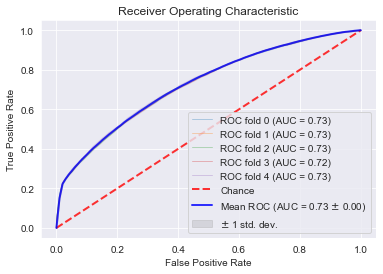

True Negative:  55537
False Positive: 23933
False Negative: 29539
True Positive:  49931
              precision    recall  f1-score   support

         0.0       0.65      0.70      0.68     79470
         1.0       0.68      0.63      0.65     79470

    accuracy                           0.66    158940
   macro avg       0.66      0.66      0.66    158940
weighted avg       0.66      0.66      0.66    158940

Wall time: 2min 38s


array([[55537, 23933],
       [29539, 49931]], dtype=int64)

In [32]:
%%time

target_col = '100104'
drop_list = [i for i in TARGET_COLS if i != target_col]
trial1 = trial[trial[target_col].notnull()].drop(drop_list,axis=1)
trial1.fillna(0,inplace=True)
cols = trial1.columns

scalar = MinMaxScaler()
trial1 = pd.DataFrame(scalar.fit_transform(trial1),columns=cols)

# Split into in/dependent vars
trial1_sub = trial1.sample(n=10000,random_state=42)
X = trial1_sub.drop([target_col],axis=1)
y = trial1_sub[target_col]

cols_to_keep,dfr = find_best_cols(X,y,trial1_sub,target = target_col)

# Balance the classes
num_per_class = trial1[target_col].value_counts().min()
trial1 = trial1.sample(frac=1,random_state=42).groupby(target_col).head(num_per_class)

X = trial1.drop([target_col],axis=1)
y = trial1[target_col]

X = X[cols_to_keep]

X = X.values
y = y.values

n_samples,n_features = X.shape
random_state = np.random.RandomState(42)
cv = StratifiedKFold(n_splits=5)
clf = XGBClassifier(random_state = 42,
                   n_jobs=-1,
                   max_depth=3,
                   n_estimators = 400,
                   learning_rate = 0.1,
                   min_child_weight = 4)

tprs,aucs = [],[]
mean_fpr = np.linspace(0,1,100)

fig,ax = plt.subplots()

for i, (train,test) in enumerate(cv.split(X,y)):
    clf.fit(X[train],y[train],eval_metric='error')
    viz = plot_roc_curve(clf,X[test],y[test],name = 'ROC fold {}'.format(i),alpha=0.3,lw=1,ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()

X_full = trial1[cols_to_keep].values
y_full = trial1[target_col]

y_true = y_full
y_pred = clf.predict(X_full)
tn,fp,fn,tp = confusion_matrix(y_true,y_pred).ravel()
print(f'True Negative:  {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}\nTrue Positive:  {tp}')
print(classification_report(y_true,y_pred))
confusion_matrix(y_true,y_pred)


### 100107: Diabetes - Kidney

10 Last Column dropped:  YOY_DIFF_EYEEXAMSROUTINE_0 | 0


,FI,FI - rank,IV,IV - rank,VIF,VIF - rank,r1
PRIMARY_CARE_VISITS,0.105,3.000,0.165,1.000,1.444,6.000,2.000
AETNA_MED_PAID_AMT,0.109,2.000,0.120,2.000,2.418,9.000,2.000
MBR_MED_PAID_AMT,0.076,9.000,0.076,3.000,2.140,8.000,6.000
VISION_TRANSACTIONS,0.087,5.000,0.000,10.500,1.011,2.000,7.750
NY_MOOPINN,0.094,4.000,0.004,8.000,1.043,4.000,6.000
NY_PREMIUM,0.055,10.000,0.000,10.500,1.013,3.000,10.250
YOY_DIFF_PCP,0.083,8.000,0.022,6.000,1.329,5.000,7.000
YOY_DIFF_TIER1PREFRETAIL3MO,0.084,7.000,0.007,7.000,1.454,7.000,7.000
YOY_DIFF_EYEEXAMSROUTINE_0,0.221,1.000,0.027,4.500,inf,10.500,2.750
Gender_M,0.086,6.000,0.000,9.000,1.003,1.000,7.500


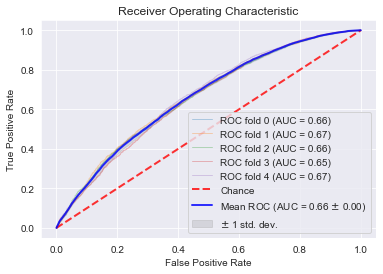

True Negative:  8993
False Positive: 5928
False Negative: 4875
True Positive:  10046
              precision    recall  f1-score   support

         0.0       0.65      0.60      0.62     14921
         1.0       0.63      0.67      0.65     14921

    accuracy                           0.64     29842
   macro avg       0.64      0.64      0.64     29842
weighted avg       0.64      0.64      0.64     29842

Wall time: 1min 37s


array([[ 8993,  5928],
       [ 4875, 10046]], dtype=int64)

In [33]:
%%time

target_col = '100107'
drop_list = [i for i in TARGET_COLS if i != target_col]
trial2 = trial[trial[target_col].notnull()].drop(drop_list,axis=1)
trial2.fillna(0,inplace=True)
cols = trial2.columns

scalar = MinMaxScaler()
trial2 = pd.DataFrame(scalar.fit_transform(trial2),columns=cols)

# Split into in/dependent vars
trial2_sub = trial2.sample(n=10000,random_state=42)
X = trial2_sub.drop([target_col],axis=1)
y = trial2_sub[target_col]

cols_to_keep,dfr = find_best_cols(X,y,trial2_sub,target = target_col)

# Balance the classes
num_per_class = trial2[target_col].value_counts().min()
trial2 = trial2.sample(frac=1,random_state=42).groupby(target_col).head(num_per_class)

X = trial2.drop([target_col],axis=1)
y = trial2[target_col]

X = X[cols_to_keep]

X = X.values
y = y.values

n_samples,n_features = X.shape
random_state = np.random.RandomState(42)
cv = StratifiedKFold(n_splits=5)
clf = XGBClassifier(random_state = 42,
                   n_jobs=-1,
                   max_depth=3,
                   n_estimators = 400,
                   learning_rate = 0.1,
                   min_child_weight = 4)

tprs,aucs = [],[]
mean_fpr = np.linspace(0,1,100)

fig,ax = plt.subplots()
for i, (train,test) in enumerate(cv.split(X,y)):
    clf.fit(X[train],y[train],eval_metric='error')
    viz = plot_roc_curve(clf,X[test],y[test],name = 'ROC fold {}'.format(i),alpha=0.3,lw=1,ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()

X_full = trial2[cols_to_keep].values
y_full = trial2[target_col]

y_true = y_full
y_pred = clf.predict(X_full)
tn,fp,fn,tp = confusion_matrix(y_true,y_pred).ravel()
print(f'True Negative:  {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}\nTrue Positive:  {tp}')
print(classification_report(y_true,y_pred))
confusion_matrix(y_true,y_pred)


### 101803: Controlling high blood pressure

10 Last Column dropped:  YOY_DIFF_MOOPINN


,FI,FI - rank,IV,IV - rank,VIF,VIF - rank,r1
PRIMARY_CARE_VISITS,0.071,7.000,0.058,1.000,1.251,9.000,4.000
AETNA_MED_PAID_AMT,0.055,9.000,0.039,2.000,1.242,8.000,5.500
MEM_PAID_VISION,0.028,11.000,0.000,11.000,1.001,1.000,11.000
NY_PCP,0.089,5.000,0.034,3.000,1.438,11.000,4.000
NY_DIALYSIS,0.177,1.000,0.029,6.000,1.118,6.000,3.500
NY_EYEEXAMSMC,0.101,4.000,0.033,4.000,1.397,10.000,4.000
NY_TIER2PREFRETAIL3MO,0.148,2.000,0.028,7.000,1.061,4.000,4.500
YOY_DIFF_EYEEXAMSMC,0.065,8.000,0.029,5.000,1.183,7.000,6.500
YOY_DIFF_HIGHDEDUCTIBLE_No | No,0.147,3.000,0.024,9.000,1.098,5.000,6.000
Gender_M,0.033,10.000,0.001,10.000,1.005,2.000,10.000


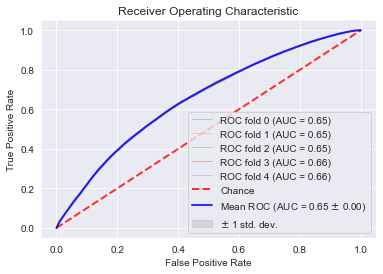

True Negative:  80876
False Positive: 55625
False Negative: 49357
True Positive:  87144
              precision    recall  f1-score   support

         0.0       0.62      0.59      0.61    136501
         1.0       0.61      0.64      0.62    136501

    accuracy                           0.62    273002
   macro avg       0.62      0.62      0.62    273002
weighted avg       0.62      0.62      0.62    273002

Wall time: 3min 57s


array([[80876, 55625],
       [49357, 87144]], dtype=int64)

In [34]:
%%time

target_col = '101803'
drop_list = [i for i in TARGET_COLS if i != target_col]
trial3 = trial[trial[target_col].notnull()].drop(drop_list,axis=1)
trial3.fillna(0,inplace=True)
cols = trial3.columns

scalar = MinMaxScaler()
trial3 = pd.DataFrame(scalar.fit_transform(trial3),columns=cols)

# Split into in/dependent vars
trial3_sub = trial3.sample(n=10000,random_state=42)
X = trial3_sub.drop([target_col],axis=1)
y = trial3_sub[target_col]

cols_to_keep,dfr = find_best_cols(X,y,trial3_sub,target = target_col)

# Balance the classes
num_per_class = trial3[target_col].value_counts().min()
trial3 = trial3.sample(frac=1,random_state=42).groupby(target_col).head(num_per_class)

X = trial3.drop([target_col],axis=1)
y = trial3[target_col]

X = X[cols_to_keep]

X = X.values
y = y.values

n_samples,n_features = X.shape
random_state = np.random.RandomState(42)
cv = StratifiedKFold(n_splits=5)
clf = XGBClassifier(random_state = 42,
                   n_jobs=-1,
                   max_depth=3,
                   n_estimators = 400,
                   learning_rate = 0.1,
                   min_child_weight = 4)

tprs,aucs = [],[]
mean_fpr = np.linspace(0,1,100)

fig,ax = plt.subplots()
for i, (train,test) in enumerate(cv.split(X,y)):
    clf.fit(X[train],y[train],eval_metric='error')
    viz = plot_roc_curve(clf,X[test],y[test],name = 'ROC fold {}'.format(i),alpha=0.3,lw=1,ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()

X_full = trial3[cols_to_keep].values
y_full = trial3[target_col]

y_true = y_full
y_pred = clf.predict(X_full)
tn,fp,fn,tp = confusion_matrix(y_true,y_pred).ravel()
print(f'True Negative:  {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}\nTrue Positive:  {tp}')
print(classification_report(y_true,y_pred))
confusion_matrix(y_true,y_pred)


### 201180: Diabetes Adherence

10 Last Column dropped:  PRIMARY_CARE_VISITS


,FI,FI - rank,IV,IV - rank,VIF,VIF - rank,r1
Age,0.079,10.000,0.016,1.000,1.010,4.000,5.500
AETNA_MED_PAID_AMT,0.114,3.000,0.000,9.000,1.398,8.000,6.000
MEM_PAID_VISION,0.016,11.000,0.001,8.000,1.003,1.000,9.500
NY_LAB,0.085,8.000,0.000,10.500,1.007,3.000,9.250
NY_RXDEDUCTIBLE,0.118,1.000,0.000,10.500,1.403,10.000,5.750
YOY_DIFF_PCP,0.103,5.000,0.001,6.000,1.341,6.000,5.500
YOY_DIFF_RXDEDUCTIBLE,0.092,6.000,0.011,2.000,1.400,9.000,4.000
YOY_DIFF_EYEEXAMSROUTINE_0,0.085,7.000,0.006,4.000,1.376,7.000,5.500
Plan_Type_HMO,0.117,2.000,0.001,7.000,1.057,5.000,4.500
Gender_M,0.108,4.000,0.009,3.000,1.004,2.000,3.500


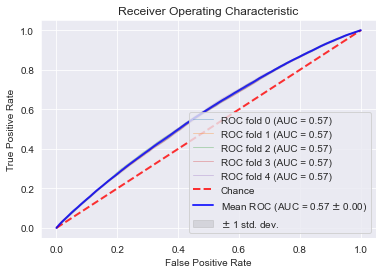

True Negative:  54892
False Positive: 52586
False Negative: 42077
True Positive:  65401
              precision    recall  f1-score   support

         0.0       0.57      0.51      0.54    107478
         1.0       0.55      0.61      0.58    107478

    accuracy                           0.56    214956
   macro avg       0.56      0.56      0.56    214956
weighted avg       0.56      0.56      0.56    214956

Wall time: 2min 59s


array([[54892, 52586],
       [42077, 65401]], dtype=int64)

In [35]:
%%time

target_col = '201180'
drop_list = [i for i in TARGET_COLS if i != target_col]
trial4 = trial[trial[target_col].notnull()].drop(drop_list,axis=1)
trial4.fillna(0,inplace=True)
cols = trial4.columns

scalar = MinMaxScaler()
trial4 = pd.DataFrame(scalar.fit_transform(trial4),columns=cols)

# Split into in/dependent vars
trial4_sub = trial4.sample(n=10000,random_state=42)
X = trial4_sub.drop([target_col],axis=1)
y = trial4_sub[target_col]

cols_to_keep,dfr = find_best_cols(X,y,trial4_sub,target = target_col)

# Balance the classes
num_per_class = trial4[target_col].value_counts().min()
trial4 = trial4.sample(frac=1,random_state=42).groupby(target_col).head(num_per_class)

X = trial4.drop([target_col],axis=1)
y = trial4[target_col]

X = X[cols_to_keep]

X = X.values
y = y.values

n_samples,n_features = X.shape
random_state = np.random.RandomState(42)
cv = StratifiedKFold(n_splits=5)
clf = XGBClassifier(random_state = 42,
                   n_jobs=-1,
                   max_depth=3,
                   n_estimators = 400,
                   learning_rate = 0.1,
                   min_child_weight = 4)

tprs,aucs = [],[]
mean_fpr = np.linspace(0,1,100)

fig,ax = plt.subplots()
for i, (train,test) in enumerate(cv.split(X,y)):
    clf.fit(X[train],y[train],eval_metric='error')
    viz = plot_roc_curve(clf,X[test],y[test],name = 'ROC fold {}'.format(i),alpha=0.3,lw=1,ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()

X_full = trial4[cols_to_keep].values
y_full = trial4[target_col]

y_true = y_full
y_pred = clf.predict(X_full)
tn,fp,fn,tp = confusion_matrix(y_true,y_pred).ravel()
print(f'True Negative:  {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}\nTrue Positive:  {tp}')
print(classification_report(y_true,y_pred))
confusion_matrix(y_true,y_pred)


### 999998: Diabetes Blood Sugar Controlled

10 Last Column dropped:  NY_MOOPINN


,FI,FI - rank,IV,IV - rank,VIF,VIF - rank,r1
Age,0.054,7.000,0.029,3.000,1.025,3.000,5.000
PRIMARY_CARE_VISITS,0.046,9.000,0.004,6.000,1.029,4.000,7.500
MEM_PAID_VISION,0.012,11.000,0.000,11.000,1.002,2.000,11.000
NY_DIALYSIS,0.147,2.000,0.008,5.000,1.098,5.000,3.500
NY_EYEEXAMSMC,0.083,3.000,0.003,8.000,1.494,8.000,5.500
YOY_DIFF_TIER1PREFRETAIL1MO,0.077,4.000,0.009,4.000,1.102,6.000,4.000
YOY_DIFF_TIER1PREFRETAIL3MO,0.073,5.000,0.003,7.000,1.114,7.000,6.000
Plan_Type_HMO,0.047,8.000,0.052,2.000,23.332,10.000,5.000
Plan_Type_PPO,0.363,1.000,0.055,1.000,23.436,11.000,1.000
Gender_M,0.031,10.000,0.001,10.000,1.001,1.000,10.000


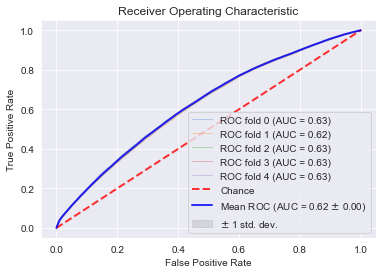

True Negative:  63208
False Positive: 44908
False Negative: 43207
True Positive:  64909
              precision    recall  f1-score   support

         0.0       0.59      0.58      0.59    108116
         1.0       0.59      0.60      0.60    108116

    accuracy                           0.59    216232
   macro avg       0.59      0.59      0.59    216232
weighted avg       0.59      0.59      0.59    216232

Wall time: 1min 59s


array([[63208, 44908],
       [43207, 64909]], dtype=int64)

In [36]:
%%time

target_col = '999998'
drop_list = [i for i in TARGET_COLS if i != target_col]
trial5 = trial[trial[target_col].notnull()].drop(drop_list,axis=1)
trial5.fillna(0,inplace=True)
cols = trial5.columns

scalar = MinMaxScaler()
trial5 = pd.DataFrame(scalar.fit_transform(trial5),columns=cols)

# Split into in/dependent vars
trial5_sub = trial5.sample(n=10000,random_state=42)
X = trial5_sub.drop([target_col],axis=1)
y = trial5_sub[target_col]

cols_to_keep,dfr = find_best_cols(X,y,trial5_sub,target = target_col)

# Balance the classes
num_per_class = trial5[target_col].value_counts().min()
trial5 = trial5.sample(frac=1,random_state=42).groupby(target_col).head(num_per_class)

X = trial5.drop([target_col],axis=1)
y = trial5[target_col]

X = X[cols_to_keep]

X = X.values
y = y.values

n_samples,n_features = X.shape
random_state = np.random.RandomState(42)
cv = StratifiedKFold(n_splits=5)
clf = XGBClassifier(random_state = 42,
                   n_jobs=-1,
                   max_depth=3,
                   n_estimators = 400,
                   learning_rate = 0.1,
                   min_child_weight = 4)

tprs,aucs = [],[]
mean_fpr = np.linspace(0,1,100)

fig,ax = plt.subplots()
for i, (train,test) in enumerate(cv.split(X,y)):
    clf.fit(X[train],y[train],eval_metric='error')
    viz = plot_roc_curve(clf,X[test],y[test],name = 'ROC fold {}'.format(i),alpha=0.3,lw=1,ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()

X_full = trial5[cols_to_keep].values
y_full = trial5[target_col]

y_true = y_full
y_pred = clf.predict(X_full)
tn,fp,fn,tp = confusion_matrix(y_true,y_pred).ravel()
print(f'True Negative:  {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}\nTrue Positive:  {tp}')
print(classification_report(y_true,y_pred))
confusion_matrix(y_true,y_pred)


In [37]:
# 100104: Diabetes - EYE
# 100107: Diabetes - Kidney
# 101803: Controlling high blood pressure
# 201180: Diabetes Adherence
# 999998: Diabetes Blood Sugar Controlled

In [38]:
print(f'{trial1.shape}{trial2.shape}{trial3.shape}{trial4.shape}{trial5.shape}')

(158940, 47)(29842, 47)(273002, 47)(214956, 47)(216232, 47)


In [39]:
trial1.sample(3,random_state=42)

,Age,100104,PRIMARY_CARE_VISITS,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,DR_TRANSACTIONS,DR_VISITS,DR_MBR_PAID_AMT,VISION_TRANSACTIONS,MEM_PAID_VISION,NY_MOOPINN,NY_PREMIUM,NY_PCP,NY_LAB,NY_DIALYSIS,NY_EYEEXAMSMC,NY_EYEEXAMSROUTINE,NY_RXDEDUCTIBLE,NY_TIER1PREFRETAIL1MO,NY_TIER2PREFRETAIL1MO,NY_TIER1PREFRETAIL3MO,NY_TIER2PREFRETAIL3MO,YOY_DIFF_MOOPINN,YOY_DIFF_PREMIUM,YOY_DIFF_PCP,YOY_DIFF_LAB,YOY_DIFF_DIALYSIS,YOY_DIFF_EYEEXAMSMC,YOY_DIFF_RXDEDUCTIBLE,YOY_DIFF_TIER1PREFRETAIL1MO,YOY_DIFF_TIER2PREFRETAIL1MO,YOY_DIFF_TIER1PREFRETAIL3MO,YOY_DIFF_TIER2PREFRETAIL3MO,YOY_DIFF_HIGHDEDUCTIBLE_No | No,YOY_DIFF_HIGHDEDUCTIBLE_No | Yes,YOY_DIFF_HIGHDEDUCTIBLE_Yes | No,YOY_DIFF_HIGHDEDUCTIBLE_Yes | Yes,YOY_DIFF_EYEEXAMSROUTINE_0,YOY_DIFF_EYEEXAMSROUTINE_0 | 0,YOY_DIFF_EYEEXAMSROUTINE_Not Covered | 0,NY_HIGHDEDUCTIBLE_No,NY_HIGHDEDUCTIBLE_Yes,Plan_Type_HMO,Plan_Type_POS,Plan_Type_PPO,Plan_Type_RPPO,Gender_M
121523,0.877,1.000,0.024,0.002,0.073,0.000,0.000,0.000,0.000,0.000,0.564,0.000,0.286,0.000,0.500,0.900,0.000,0.000,0.000,0.000,0.000,0.000,0.600,0.667,0.680,0.633,0.000,0.947,0.182,0.400,0.250,0.286,0.250,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000
33159,0.825,0.000,0.024,0.053,0.436,0.079,0.078,0.348,0.000,0.000,0.830,0.000,0.143,0.094,0.500,0.700,0.000,0.241,0.400,0.500,0.000,0.500,0.600,0.667,0.620,0.600,0.000,0.421,0.491,0.400,0.500,0.000,0.500,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000
73043,0.596,1.000,0.010,0.001,0.066,0.000,0.000,0.000,0.000,0.000,0.957,0.000,0.286,0.062,0.500,0.900,0.000,0.000,0.000,1.000,0.000,1.000,0.600,0.667,0.700,0.667,0.000,0.474,0.455,0.400,0.750,0.286,0.750,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000


In [40]:
trial2.sample(3,random_state=42)

,Age,100107,PRIMARY_CARE_VISITS,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,DR_TRANSACTIONS,DR_VISITS,DR_MBR_PAID_AMT,VISION_TRANSACTIONS,MEM_PAID_VISION,NY_MOOPINN,NY_PREMIUM,NY_PCP,NY_LAB,NY_DIALYSIS,NY_EYEEXAMSMC,NY_EYEEXAMSROUTINE,NY_RXDEDUCTIBLE,NY_TIER1PREFRETAIL1MO,NY_TIER2PREFRETAIL1MO,NY_TIER1PREFRETAIL3MO,NY_TIER2PREFRETAIL3MO,YOY_DIFF_MOOPINN,YOY_DIFF_PREMIUM,YOY_DIFF_PCP,YOY_DIFF_LAB,YOY_DIFF_DIALYSIS,YOY_DIFF_EYEEXAMSMC,YOY_DIFF_RXDEDUCTIBLE,YOY_DIFF_TIER1PREFRETAIL1MO,YOY_DIFF_TIER2PREFRETAIL1MO,YOY_DIFF_TIER1PREFRETAIL3MO,YOY_DIFF_TIER2PREFRETAIL3MO,YOY_DIFF_HIGHDEDUCTIBLE_No | No,YOY_DIFF_HIGHDEDUCTIBLE_No | Yes,YOY_DIFF_HIGHDEDUCTIBLE_Yes | No,YOY_DIFF_HIGHDEDUCTIBLE_Yes | Yes,YOY_DIFF_EYEEXAMSROUTINE_0,YOY_DIFF_EYEEXAMSROUTINE_0 | 0,YOY_DIFF_EYEEXAMSROUTINE_Not Covered | 0,NY_HIGHDEDUCTIBLE_No,NY_HIGHDEDUCTIBLE_Yes,Plan_Type_HMO,Plan_Type_POS,Plan_Type_PPO,Plan_Type_RPPO,Gender_M
126710,0.877,1.000,0.024,0.005,0.103,0.030,0.021,0.016,0.000,0.000,1.000,0.000,0.143,0.094,0.500,0.700,0.000,0.494,0.400,0.500,0.000,0.500,0.745,0.667,0.700,0.667,0.000,0.421,0.718,0.400,0.500,0.000,0.500,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000
84906,0.772,1.000,0.000,0.000,0.060,0.000,0.000,0.000,0.000,0.000,1.000,0.136,0.143,0.125,0.500,0.600,0.000,0.241,0.400,0.500,0.000,0.500,0.600,0.535,0.660,0.667,0.000,0.421,0.627,0.400,0.500,0.000,0.500,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000
234292,0.772,0.000,0.003,0.000,0.060,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.143,0.000,0.500,0.900,0.000,0.000,0.000,0.000,0.000,0.000,0.600,0.667,0.700,0.667,0.000,0.526,0.455,0.400,0.500,0.286,0.500,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000


In [41]:
trial3.sample(3,random_state=42)

,Age,101803,PRIMARY_CARE_VISITS,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,DR_TRANSACTIONS,DR_VISITS,DR_MBR_PAID_AMT,VISION_TRANSACTIONS,MEM_PAID_VISION,NY_MOOPINN,NY_PREMIUM,NY_PCP,NY_LAB,NY_DIALYSIS,NY_EYEEXAMSMC,NY_EYEEXAMSROUTINE,NY_RXDEDUCTIBLE,NY_TIER1PREFRETAIL1MO,NY_TIER2PREFRETAIL1MO,NY_TIER1PREFRETAIL3MO,NY_TIER2PREFRETAIL3MO,YOY_DIFF_MOOPINN,YOY_DIFF_PREMIUM,YOY_DIFF_PCP,YOY_DIFF_LAB,YOY_DIFF_DIALYSIS,YOY_DIFF_EYEEXAMSMC,YOY_DIFF_RXDEDUCTIBLE,YOY_DIFF_TIER1PREFRETAIL1MO,YOY_DIFF_TIER2PREFRETAIL1MO,YOY_DIFF_TIER1PREFRETAIL3MO,YOY_DIFF_TIER2PREFRETAIL3MO,YOY_DIFF_HIGHDEDUCTIBLE_No | No,YOY_DIFF_HIGHDEDUCTIBLE_No | Yes,YOY_DIFF_HIGHDEDUCTIBLE_Yes | No,YOY_DIFF_HIGHDEDUCTIBLE_Yes | Yes,YOY_DIFF_EYEEXAMSROUTINE_0,YOY_DIFF_EYEEXAMSROUTINE_0 | 0,YOY_DIFF_EYEEXAMSROUTINE_Not Covered | 0,NY_HIGHDEDUCTIBLE_No,NY_HIGHDEDUCTIBLE_Yes,Plan_Type_HMO,Plan_Type_POS,Plan_Type_PPO,Plan_Type_RPPO,Gender_M
332296,0.833,1.000,0.011,0.004,0.011,0.007,0.009,0.042,0.000,0.000,0.319,0.449,0.000,0.000,0.500,0.400,0.000,0.000,0.000,0.500,0.000,0.400,0.545,0.290,0.333,0.600,0.000,0.333,0.400,0.000,0.500,0.000,0.455,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000
223790,0.883,1.000,0.005,0.004,0.052,0.037,0.046,0.102,0.000,0.000,1.000,0.215,0.143,0.000,0.500,0.700,0.000,0.571,0.000,1.000,0.000,1.000,0.600,0.290,0.500,0.600,0.000,0.250,0.510,0.000,0.750,0.000,0.727,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000
122105,0.767,1.000,0.058,0.015,0.169,0.097,0.056,0.070,0.000,0.000,0.617,0.000,0.143,0.094,0.500,0.900,0.000,0.429,0.000,0.500,0.000,0.400,0.618,0.306,0.333,0.640,0.000,0.250,0.510,0.000,0.500,0.000,0.455,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000


In [42]:
trial4.sample(3,random_state=42)

,Age,201180,PRIMARY_CARE_VISITS,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,DR_TRANSACTIONS,DR_VISITS,DR_MBR_PAID_AMT,VISION_TRANSACTIONS,MEM_PAID_VISION,NY_MOOPINN,NY_PREMIUM,NY_PCP,NY_LAB,NY_DIALYSIS,NY_EYEEXAMSMC,NY_EYEEXAMSROUTINE,NY_RXDEDUCTIBLE,NY_TIER1PREFRETAIL1MO,NY_TIER2PREFRETAIL1MO,NY_TIER1PREFRETAIL3MO,NY_TIER2PREFRETAIL3MO,YOY_DIFF_MOOPINN,YOY_DIFF_PREMIUM,YOY_DIFF_PCP,YOY_DIFF_LAB,YOY_DIFF_DIALYSIS,YOY_DIFF_EYEEXAMSMC,YOY_DIFF_RXDEDUCTIBLE,YOY_DIFF_TIER1PREFRETAIL1MO,YOY_DIFF_TIER2PREFRETAIL1MO,YOY_DIFF_TIER1PREFRETAIL3MO,YOY_DIFF_TIER2PREFRETAIL3MO,YOY_DIFF_HIGHDEDUCTIBLE_No | No,YOY_DIFF_HIGHDEDUCTIBLE_No | Yes,YOY_DIFF_HIGHDEDUCTIBLE_Yes | No,YOY_DIFF_HIGHDEDUCTIBLE_Yes | Yes,YOY_DIFF_EYEEXAMSROUTINE_0,YOY_DIFF_EYEEXAMSROUTINE_0 | 0,YOY_DIFF_EYEEXAMSROUTINE_Not Covered | 0,NY_HIGHDEDUCTIBLE_No,NY_HIGHDEDUCTIBLE_Yes,Plan_Type_HMO,Plan_Type_POS,Plan_Type_PPO,Plan_Type_RPPO,Gender_M
661059,0.598,0.000,0.030,0.008,0.012,0.066,0.059,0.044,0.000,0.011,0.170,0.000,0.143,0.000,0.500,0.700,0.000,0.000,0.000,0.000,0.000,0.000,0.600,0.667,0.700,0.667,0.000,0.421,0.455,0.400,0.500,0.286,0.500,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000
316941,0.622,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.011,0.298,0.000,0.000,0.000,0.500,0.400,0.000,0.494,0.000,0.000,0.000,0.000,0.600,0.667,0.700,0.667,0.000,0.474,0.082,0.400,0.250,0.286,0.250,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000
334908,0.585,1.000,0.004,0.001,0.008,0.000,0.000,0.000,0.143,0.011,1.000,0.000,0.143,0.000,0.500,0.800,0.000,0.000,0.000,0.000,0.000,0.000,0.600,0.667,0.500,0.600,0.000,0.421,0.455,0.000,0.250,0.000,0.250,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000


In [43]:
trial5.sample(3,random_state=42)

,Age,999998,PRIMARY_CARE_VISITS,AETNA_MED_PAID_AMT,MBR_MED_PAID_AMT,DR_TRANSACTIONS,DR_VISITS,DR_MBR_PAID_AMT,VISION_TRANSACTIONS,MEM_PAID_VISION,NY_MOOPINN,NY_PREMIUM,NY_PCP,NY_LAB,NY_DIALYSIS,NY_EYEEXAMSMC,NY_EYEEXAMSROUTINE,NY_RXDEDUCTIBLE,NY_TIER1PREFRETAIL1MO,NY_TIER2PREFRETAIL1MO,NY_TIER1PREFRETAIL3MO,NY_TIER2PREFRETAIL3MO,YOY_DIFF_MOOPINN,YOY_DIFF_PREMIUM,YOY_DIFF_PCP,YOY_DIFF_LAB,YOY_DIFF_DIALYSIS,YOY_DIFF_EYEEXAMSMC,YOY_DIFF_RXDEDUCTIBLE,YOY_DIFF_TIER1PREFRETAIL1MO,YOY_DIFF_TIER2PREFRETAIL1MO,YOY_DIFF_TIER1PREFRETAIL3MO,YOY_DIFF_TIER2PREFRETAIL3MO,YOY_DIFF_HIGHDEDUCTIBLE_No | No,YOY_DIFF_HIGHDEDUCTIBLE_No | Yes,YOY_DIFF_HIGHDEDUCTIBLE_Yes | No,YOY_DIFF_HIGHDEDUCTIBLE_Yes | Yes,YOY_DIFF_EYEEXAMSROUTINE_0,YOY_DIFF_EYEEXAMSROUTINE_0 | 0,YOY_DIFF_EYEEXAMSROUTINE_Not Covered | 0,NY_HIGHDEDUCTIBLE_No,NY_HIGHDEDUCTIBLE_Yes,Plan_Type_HMO,Plan_Type_POS,Plan_Type_PPO,Plan_Type_RPPO,Gender_M
173919,0.772,1.000,0.078,0.062,0.210,0.030,0.028,0.049,0.000,0.000,0.468,0.000,0.000,0.000,0.500,0.500,0.000,0.633,0.000,0.500,0.000,0.500,0.600,0.667,0.700,0.667,0.000,0.474,0.736,0.400,0.750,0.286,0.750,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000
212440,0.807,1.000,0.010,0.005,0.118,0.000,0.000,0.000,0.000,0.000,0.830,0.000,0.143,0.094,0.500,0.700,0.000,0.506,0.000,1.000,0.000,0.833,0.600,0.667,0.700,0.667,0.000,0.474,0.645,0.000,0.750,0.286,0.667,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000
113047,0.860,0.000,0.014,0.001,0.063,0.000,0.000,0.000,0.000,0.000,0.830,0.000,0.143,0.094,0.500,0.700,0.000,0.241,0.400,0.500,0.000,0.500,0.600,0.667,0.620,0.600,0.000,0.421,0.491,0.400,0.500,0.000,0.500,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000


In [44]:
df.shape

(4995430, 190)

In [45]:
# df.sample(500).to_clipboard()

In [46]:
null_counts = df.isnull().sum()

<AxesSubplot:>

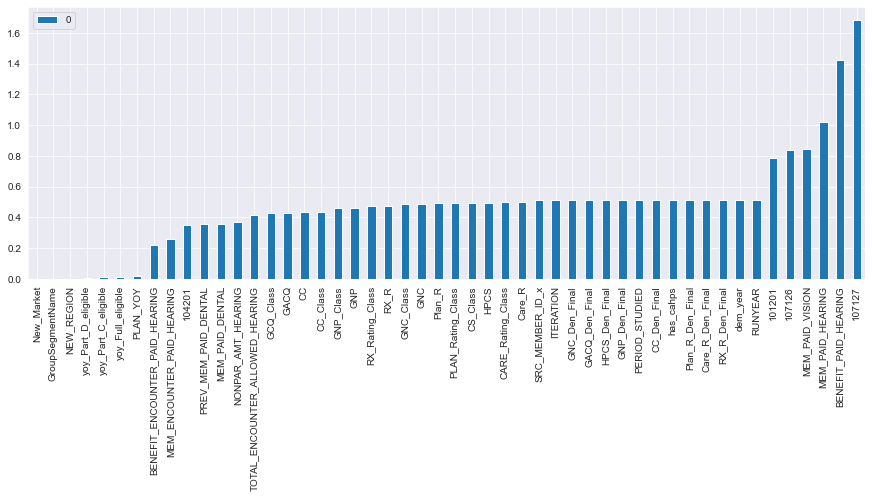

In [47]:
high_null_count = pd.DataFrame(data = (100 - (100 *null_counts/len(df))).sort_values(ascending=True)[:50])
high_null_count.plot(kind='bar',figsize=(15,5))
# This graph shows the percentage of the least populated columns

<AxesSubplot:>

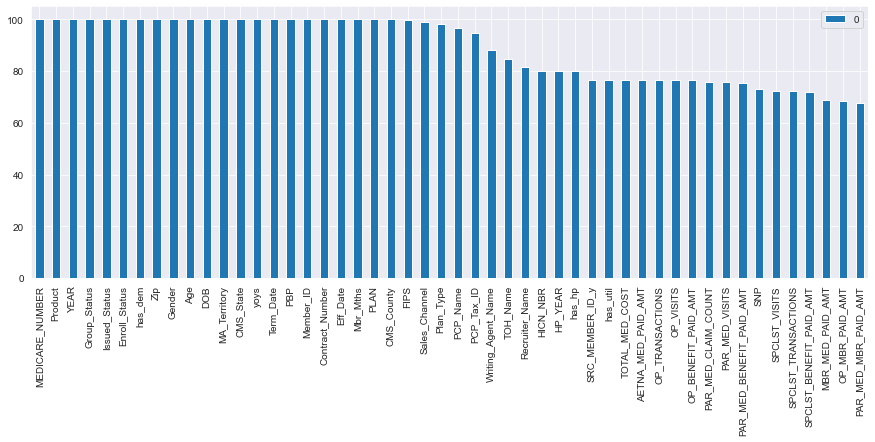

In [48]:
low_null_count = pd.DataFrame(data = (100 - (100 *null_counts/len(df))).sort_values(ascending=False)[:50])
low_null_count.plot(kind='bar',figsize=(15,5))
# This graph shows the percentage of the most populated columns

In [49]:
df.groupby('yoys')['MEDICARE_NUMBER'].count()

yoys
2017-2018     924935
2018-2019    1184834
2019-2020    1375108
2020-2021    1510553
Name: MEDICARE_NUMBER, dtype: int64

In [50]:
df.groupby('yoys')['has_cahps'].count()

yoys
2017-2018     6575
2018-2019     5880
2019-2020    13191
2020-2021        0
Name: has_cahps, dtype: int64

In [51]:
df.groupby('yoys')['has_hp'].count()

yoys
2017-2018     679200
2018-2019     892866
2019-2020    1147375
2020-2021    1273292
Name: has_hp, dtype: int64

In [52]:
df.groupby('yoys')['has_util'].count()

yoys
2017-2018     417653
2018-2019     715327
2019-2020    1298626
2020-2021    1399213
Name: has_util, dtype: int64

In [53]:
df.groupby('yoys')['Plan_Type'].value_counts()

yoys       Plan_Type
2017-2018  PPO          554277
           HMO          347189
           RPPO           2863
           DSNP             14
           HIDE             12
2018-2019  PPO          762696
           HMO          395255
           RPPO           4114
           HIDE            638
           DSNP            577
2019-2020  PPO          915959
           HMO          394947
           DSNP          23638
           POS           11449
           RPPO           3713
           HIDE           1748
2020-2021  PPO          990695
           HMO          433193
           DSNP          44644
           POS            9305
           HIDE           3711
           RPPO           2787
           FIDE-SNP        287
Name: Plan_Type, dtype: int64

In [54]:
df.groupby('yoys')['SNP'].value_counts()

yoys       SNP
2017-2018  N       274491
           Y        16607
2018-2019  N       496842
           Y        18078
2019-2020  N      1326059
           Y        25395
2020-2021  N      1435979
           Y        48643
Name: SNP, dtype: int64

In [55]:
df.groupby('yoys')['LIS_Flag'].value_counts()

yoys       LIS_Flag
2017-2018  1.000        76169
           2.000        32172
           3.000        21501
           4.000        12473
2018-2019  1.000       103139
           2.000        39689
           3.000        23151
           4.000        15843
2019-2020  1.000       138795
           2.000        53125
           3.000        29131
           4.000        15825
2020-2021  1.000       157042
           2.000        72173
           3.000        30674
           4.000        15936
Name: LIS_Flag, dtype: int64

In [56]:
print(*list(df.select_dtypes(include=['object']).columns),sep='\n')

MEDICARE_NUMBER
Member_ID
Eff_Date
Term_Date
Contract_Number
Product
CMS_County
CMS_State
MA_Territory
DOB
Gender
FIPS
Plan_Type
PCP_Name
PCP_Tax_ID
GroupName
GroupNumber
TRR_Parent_Name
TOH_Name
Recruiter_Name
Writing_Agent_Name
Sales_Channel
SNP
Enroll_Status
Issued_Status
Group_Status
yoys
SRC_MEMBER_ID_x
RX_Rating_Class
CARE_Rating_Class
PLAN_Rating_Class
GNC_Class
GCQ_Class
CS_Class
CC_Class
GNP_Class
PERIOD_STUDIED
HICN_NBR
SRC_MEMBER_ID_y
PLAN
PLAN_YOY
